<div id = 3 style="color:white;
           display:fill;
           border-radius:20px;
           background-color:#b02222;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 6rem;
              color:white;
          text-align:center;
          margin:10 auto;
          ">
    ITERATION 8: Make nearest station normally distributed (and explore dates)


</h2>
</div>

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
import missingno as msno

import warnings

from functions_20221023 import get_columns, add_supplements, feature_engineer

In [104]:
VERSION = '07'

warnings.filterwarnings("ignore")

In [105]:
LABEL = 'Price'

columns, booleans, floats, categories, custom = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)

columns.insert(0, LABEL)
print(colored(f"label", "green"), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType', 'listingHistory.listingUpdateReason']
label ->  Price


In [106]:
IN_COLAB = False

filename = f'df_listings_v{VERSION}.csv'
#remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'

df_pathname_raw = f'../../data/source/{filename}'
#df_pathname_tidy = f'../../data/final/{filename}'

df_orig = pd.read_csv(df_pathname_raw, on_bad_lines='error', index_col=0)

In [107]:
df = add_supplements(df_orig)
df = feature_engineer(df, version=VERSION)

['\nground rent: £150 p.a. ' '   semi-detached property'
 " 'for sale by online auction, starting bid of£250,000, terms and conditions apply'."
 ...
 '‘a’rated energy efficiency apartments ensuring huge savings on energy bills'
 '‘mansion block’ style ex-local authority apartment' '‘nash built’ house'] [1 1 1 ... 1 1 1]
118449 118449


In [108]:
df = df[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54067 entries, 14520525 to 126181118
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Price                               54067 non-null  int64  
 1   bedrooms                            52265 non-null  float64
 2   bathrooms                           50569 non-null  float64
 3   nearestStation                      54067 non-null  float64
 4   location.latitude                   54057 non-null  float64
 5   location.longitude                  54067 non-null  float64
 6   latitude_deviation                  54057 non-null  float64
 7   longitude_deviation                 54067 non-null  float64
 8   tenure.tenureType                   50413 non-null  object 
 9   listingHistory.listingUpdateReason  54065 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 4.5+ MB


In [109]:
df.head()

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
14520525  550000       3.0        1.0        0.274316          51.529950   
27953107  400000       2.0        2.0        0.305845          51.549390   
33593487  579950       2.0        1.0        0.438045          51.447180   
35271294  370000       2.0        1.0        0.399307          51.449568   
35429088  599950       2.0        1.0        0.238187          51.577030   

          location.longitude  latitude_deviation  longitude_deviation  \
14520525           -0.207020            0.030472             0.101800   
27953107           -0.482600            0.049912             0.377380   
33593487           -0.338770            0.052298             0.233550   
35271294           -0.140154            0.049910             0.034934   
35429088           -0.141230            0.077552             0.036010   

         tenure.tenureType listingHistory.listingUpdateReason  
14520525         LEASEHOLD                Added on 24/05/2022  
27953107         LEASEHOLD                Added on 16/06/2022  
33593487          FREEHOLD                Added on 11/07/2022  
35271294         LEASEHOLD                Added on 14/06/2021  
35429088               NaN                Added on 14/07/2015

In [110]:
try:
    df['date'] = df['listingHistory.listingUpdateReason'].str.extract('(\d\d/\d\d/\d\d\d\d)')
    df.drop('listingHistory.listingUpdateReason', axis=1, inplace=True)
except:
    pass


df['date'] = pd.to_datetime(df['date'])
df

df.describe(include=['datetime64'], exclude=[]).T

count unique        top freq      first       last
date  53259    821 2022-06-13  496 2015-01-11 2022-12-08

In [111]:
df.info()
df['date'].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 54067 entries, 14520525 to 126181118
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Price                54067 non-null  int64         
 1   bedrooms             52265 non-null  float64       
 2   bathrooms            50569 non-null  float64       
 3   nearestStation       54067 non-null  float64       
 4   location.latitude    54057 non-null  float64       
 5   location.longitude   54067 non-null  float64       
 6   latitude_deviation   54057 non-null  float64       
 7   longitude_deviation  54067 non-null  float64       
 8   tenure.tenureType    50413 non-null  object        
 9   date                 53259 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 4.5+ MB


14520525   2022-05-24
27953107   2022-06-16
33593487   2022-11-07
35271294   2021-06-14
35429088   2015-07-14
44749111   2021-11-10
46204665   2018-08-10
49020666   2021-11-10
49036279   2021-09-16
49303873   2022-03-28
Name: date, dtype: datetime64[ns]

In [112]:
import numpy as np


def detect_outlier(name, data, q1_idx=25, q3_idx=75):
    # find q1 and q3 values

    if data.dtype in ['object','category']: return [], []
    data.dropna(inplace=True)
    q1, q3 = np.percentile(sorted(data), [q1_idx, q3_idx])

    # compute IRQ
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    if data.dtype == float:
        outliers = np.array([x for x in data if x < lower_bound or x > upper_bound]).round(2)
        valid = np.array([x for x in data if lower_bound <= x <= upper_bound]).round(2)
    else:
        outliers = [x for x in data if x < lower_bound or x > upper_bound]
        valid = [x for x in data if lower_bound <= x <= upper_bound]

    return outliers, valid


outliers_df = pd.DataFrame()

for each in df.columns:
    outliers, valid = detect_outlier(each, df[each], q1_idx=0.1, q3_idx=99.9)

    min_outlier = min(outliers) if len(outliers) > 0 else None
    max_outlier = max(outliers) if len(outliers) > 0 else None

    min_valid = min(valid) if len(valid) > 0 else None
    max_valid = max(valid) if len(valid) > 0 else None

    under = [x for x in outliers if x < min_valid]
    under_max = min(under) if len(under) > 0 else None

    outl_series = pd.Series([sorted(set(outliers)), sorted(list(set(valid))), len(outliers), len(df), under_max, min_valid, max_valid, min_outlier, max_outlier])
    outliers_df[each] = outl_series

outliers_df.index = ['outliers', 'valid','count', 'totol_entries', 'under_outlr', 'min_valid', 'max_valid', 'min_outlr', 'max_outlr']
outliers_df.T


outliers  \
Price                                                               []   
bedrooms                                                    [490000.0]   
bathrooms                                                 [11.0, 12.0]   
nearestStation       [7.82, 7.88, 8.06, 8.49, 11.46, 13.77, 16.15, ...   
location.latitude                                                   []   
location.longitude    [51.4, 51.42, 51.47, 51.48, 51.52, 51.54, 51.56]   
latitude_deviation                                                  []   
longitude_deviation  [51.51, 51.52, 51.57, 51.58, 51.63, 51.64, 51.66]   
tenure.tenureType                                                   []   
date                                                                []   

                                                                 valid count  \
Price                [100000, 100500, 101250, 102000, 102500, 10312...     0   
bedrooms                           [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]     1   
bathrooms                                    [1.0, 2.0, 3.0, 4.0, 5.0]     2   
nearestStation       [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...    12   
location.latitude    [51.3, 51.31, 51.32, 51.33, 51.34, 51.35, 51.3...     0   
location.longitude   [-0.5, -0.49, -0.48, -0.47, -0.46, -0.45, -0.4...    10   
latitude_deviation   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...     0   
longitude_deviation  [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...    10   
tenure.tenureType                                                   []     0   
date                 [2015-01-11 00:00:00, 2015-07-14 00:00:00, 201...     0   

                    totol_entries under_outlr            min_valid  \
Price                       54067        None               100000   
bedrooms                    54067        None                  1.0   
bathrooms                   54067        None                  1.0   
nearestStation              54067        None                  0.0   
location.latitude           54067        None                 51.3   
location.longitude          54067        None                 -0.5   
latitude_deviation          54067        None                  0.0   
longitude_deviation         54067        None                  0.0   
tenure.tenureType           54067        None                 None   
date                        54067        None  2015-01-11 00:00:00   

                               max_valid min_outlr max_outlr  
Price                             600000      None      None  
bedrooms                             7.0  490000.0  490000.0  
bathrooms                            5.0      11.0      12.0  
nearestStation                      7.38      7.82    192.43  
location.latitude                  51.68      None      None  
location.longitude                  0.28      51.4     51.56  
latitude_deviation                   0.2      None      None  
longitude_deviation                 0.39     51.51     51.66  
tenure.tenureType                   None      None      None  
date                 2022-12-08 00:00:00      None      None

<AxesSubplot: >

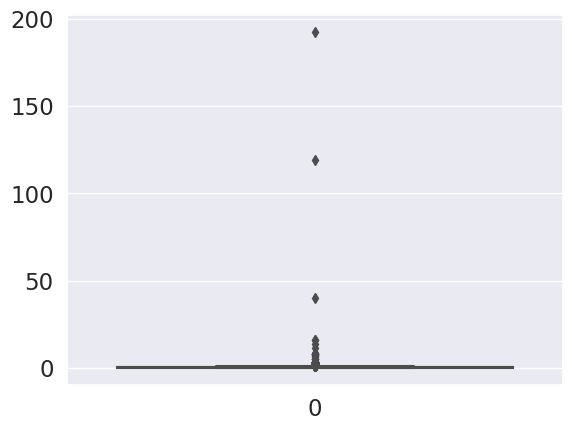

In [113]:
# Box Plot
import seaborn as sns

sns.boxplot(df['nearestStation'])

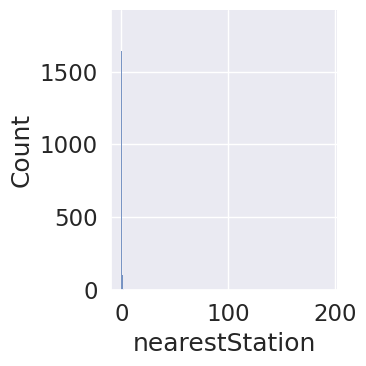

In [114]:
sns.displot(df['nearestStation'], height=4)

In [115]:
#df['station_transformed'] = np.log10(df['nearestStation']) # can't log10 negative values
#sns.distplot(df['station_transformed'])
#df[['nearestStation','station_transformed']].describe()
#df['station_transformed'].head()

In [116]:
print(len(df_orig))
old_length = len(df_orig)

print(f"{old_length} ==> {len(df)}")
old_length = len(df)


54067
54067 ==> 54067


In [117]:
df['tenure.tenureType'] = df['tenure.tenureType'].astype('category')

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

54067 ==> 54067


In [118]:
df.describe().T

count           mean            std            min  \
Price                54067.0  416448.380528  113505.624206  100000.000000   
bedrooms             52265.0      11.360145    2143.329175       1.000000   
bathrooms            50569.0       1.181534       0.413244       1.000000   
nearestStation       54067.0       0.442075       1.049040       0.000000   
location.latitude    54057.0      51.496130       0.076650      51.298317   
location.longitude   54067.0      -0.106239       0.718769      -0.498315   
latitude_deviation   54057.0       0.063545       0.042994       0.000000   
longitude_deviation  54067.0       0.133758       0.706214       0.000000   

                               25%            50%            75%  \
Price                325000.000000  425000.000000  500000.000000   
bedrooms                  1.000000       2.000000       2.000000   
bathrooms                 1.000000       1.000000       1.000000   
nearestStation            0.221778       0.361208       0.553963   
location.latitude        51.439070      51.499478      51.554067   
location.longitude       -0.212965      -0.105220      -0.012998   
latitude_deviation        0.027538       0.057198       0.093844   
longitude_deviation       0.044160       0.098877       0.192164   

                               max  
Price                600000.000000  
bedrooms             490000.000000  
bathrooms                12.000000  
nearestStation          192.431869  
location.latitude        51.683185  
location.longitude       51.558746  
latitude_deviation        0.201161  
longitude_deviation      51.663966

In [119]:
df.describe(include=['object', 'category','datetime64'], exclude=[]).T

count unique                  top   freq      first  \
tenure.tenureType  50413      4            LEASEHOLD  31582        NaT   
date               53259    821  2022-06-13 00:00:00    496 2015-01-11   

                        last  
tenure.tenureType        NaT  
date              2022-12-08

In [120]:
def get_weekday(date):
    return date.weekday()

df['date'] = df['date'].map(pd.to_datetime)
df['weekday'] = df['date'].map(get_weekday)
df['month'] = df['date'].map(lambda x : x.month)
df['day_of_month'] = df['date'].map(lambda x : x.day)
df

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
14520525   550000       3.0        1.0        0.274316          51.529950   
27953107   400000       2.0        2.0        0.305845          51.549390   
33593487   579950       2.0        1.0        0.438045          51.447180   
35271294   370000       2.0        1.0        0.399307          51.449568   
35429088   599950       2.0        1.0        0.238187          51.577030   
...           ...       ...        ...             ...                ...   
126179672  600000       3.0        2.0        0.545665          51.357170   
126180107  419999       2.0        1.0        0.191407          51.531415   
126180704  475000       2.0        1.0        0.308609          51.543141   
126180962  450000       NaN        1.0        0.476935          51.592105   
126181118  525000       2.0        1.0        0.238489          51.424589   

           location.longitude  latitude_deviation  longitude_deviation  \
14520525            -0.207020            0.030472             0.101800   
27953107            -0.482600            0.049912             0.377380   
33593487            -0.338770            0.052298             0.233550   
35271294            -0.140154            0.049910             0.034934   
35429088            -0.141230            0.077552             0.036010   
...                       ...                 ...                  ...   
126179672           -0.074740            0.142308             0.030480   
126180107           -0.052964            0.031937             0.052256   
126180704            0.011498            0.043663             0.116718   
126180962           -0.008233            0.092627             0.096987   
126181118           -0.206790            0.074889             0.101570   

           tenure.tenureType       date  weekday  month  day_of_month  
14520525           LEASEHOLD 2022-05-24      1.0    5.0          24.0  
27953107           LEASEHOLD 2022-06-16      3.0    6.0          16.0  
33593487            FREEHOLD 2022-11-07      0.0   11.0           7.0  
35271294           LEASEHOLD 2021-06-14      0.0    6.0          14.0  
35429088                 NaN 2015-07-14      1.0    7.0          14.0  
...                      ...        ...      ...    ...           ...  
126179672          LEASEHOLD 2022-08-18      3.0    8.0          18.0  
126180107          LEASEHOLD 2022-08-18      3.0    8.0          18.0  
126180704          LEASEHOLD 2022-08-18      3.0    8.0          18.0  
126180962           FREEHOLD 2022-08-18      3.0    8.0          18.0  
126181118  SHARE_OF_FREEHOLD 2022-08-18      3.0    8.0          18.0  

[54067 rows x 13 columns]

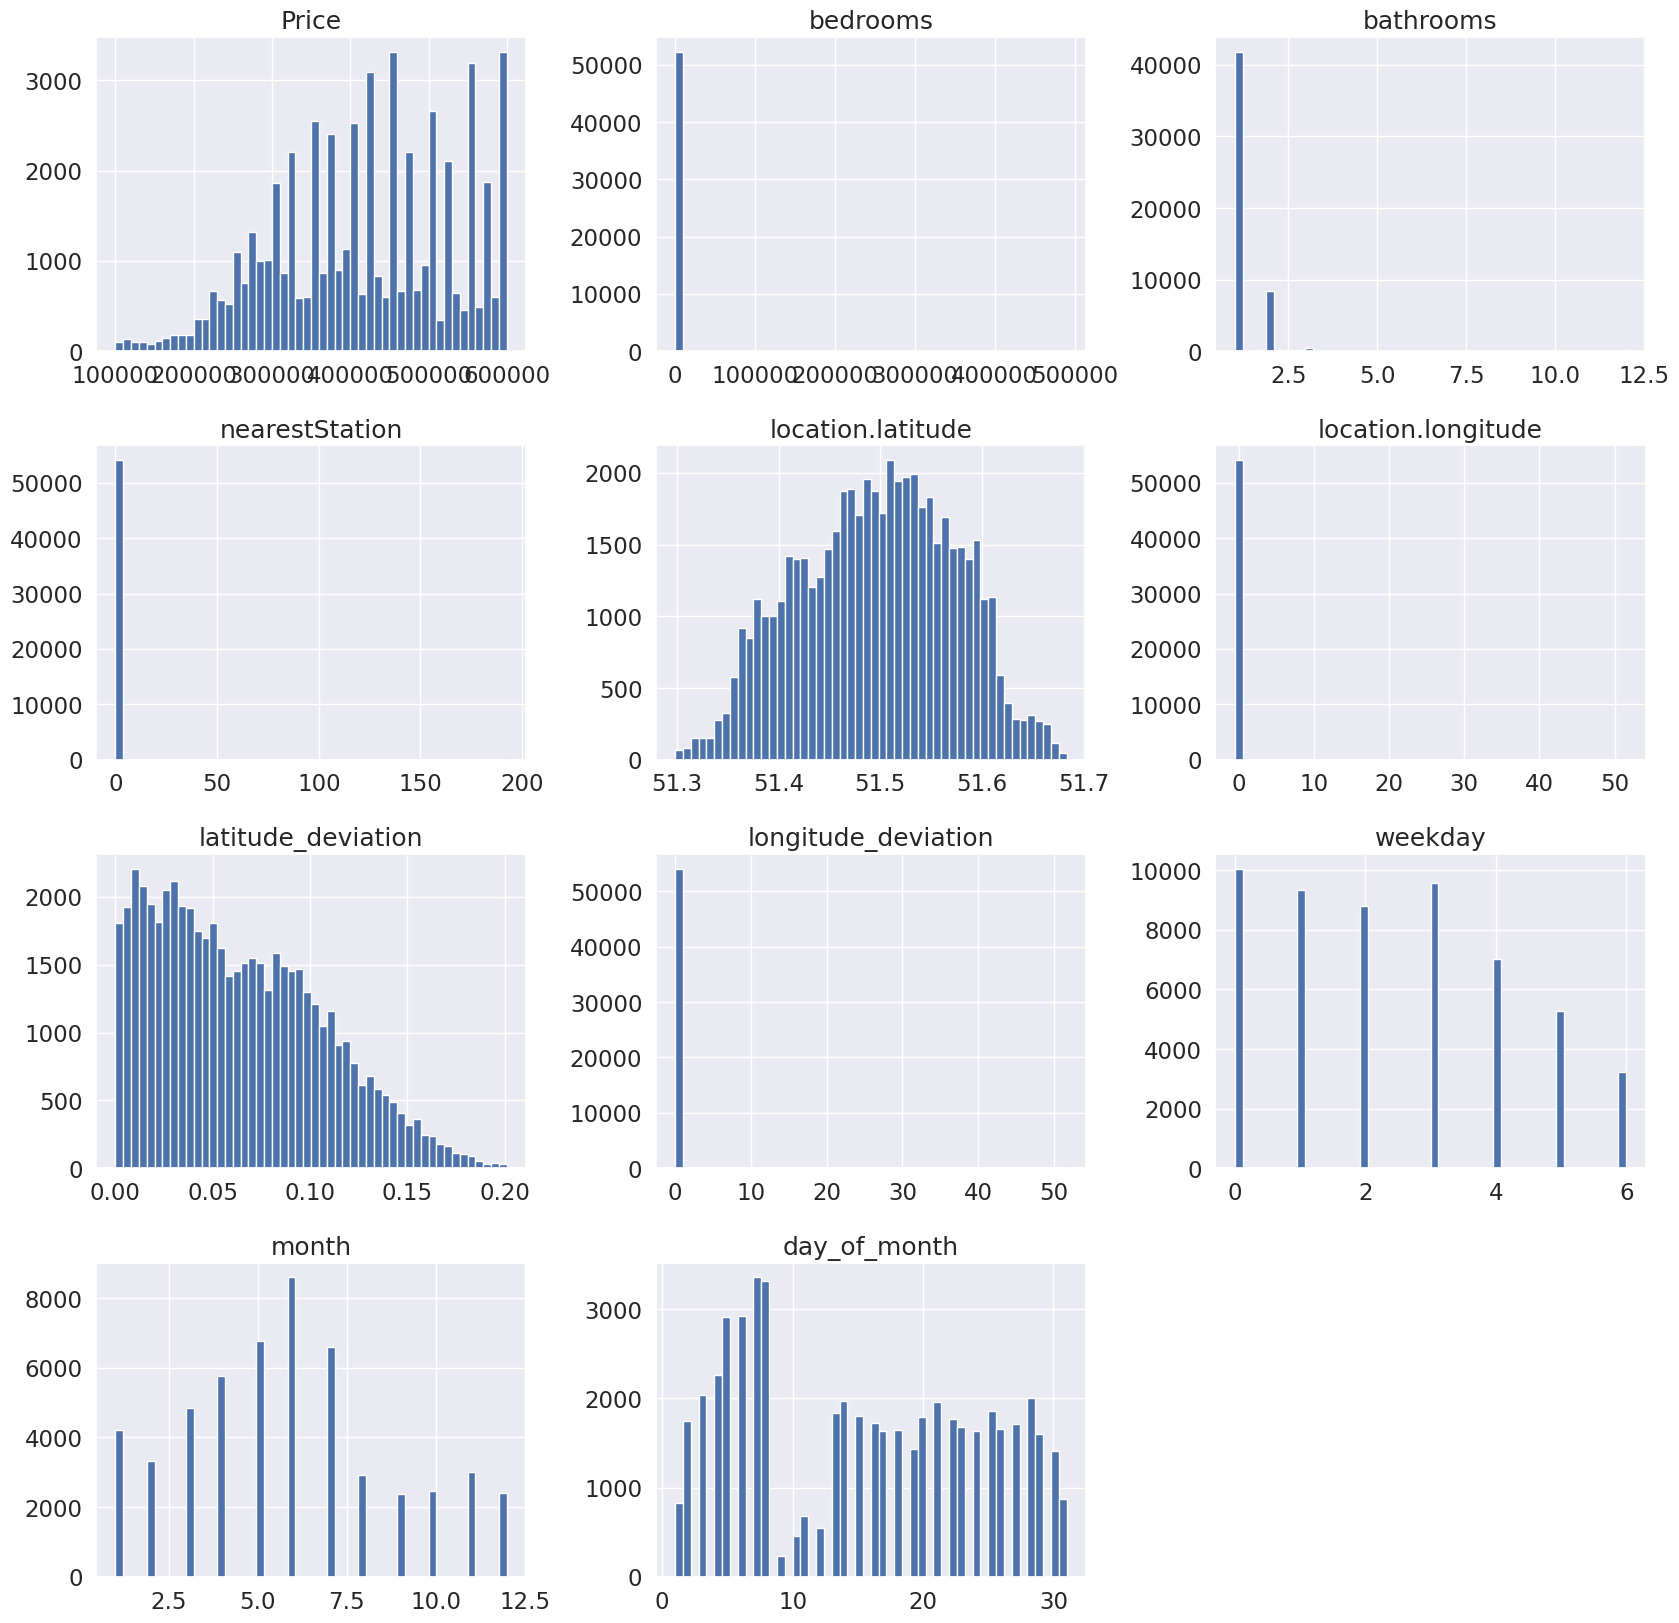

In [121]:
%matplotlib inline
df.drop(['tenure.tenureType','date'], axis=1).hist(bins=50, figsize=(20, 20))
plt.show()

In [122]:
df.drop(['tenure.tenureType','date'], axis=1)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
14520525   550000       3.0        1.0        0.274316          51.529950   
27953107   400000       2.0        2.0        0.305845          51.549390   
33593487   579950       2.0        1.0        0.438045          51.447180   
35271294   370000       2.0        1.0        0.399307          51.449568   
35429088   599950       2.0        1.0        0.238187          51.577030   
...           ...       ...        ...             ...                ...   
126179672  600000       3.0        2.0        0.545665          51.357170   
126180107  419999       2.0        1.0        0.191407          51.531415   
126180704  475000       2.0        1.0        0.308609          51.543141   
126180962  450000       NaN        1.0        0.476935          51.592105   
126181118  525000       2.0        1.0        0.238489          51.424589   

           location.longitude  latitude_deviation  longitude_deviation  \
14520525            -0.207020            0.030472             0.101800   
27953107            -0.482600            0.049912             0.377380   
33593487            -0.338770            0.052298             0.233550   
35271294            -0.140154            0.049910             0.034934   
35429088            -0.141230            0.077552             0.036010   
...                       ...                 ...                  ...   
126179672           -0.074740            0.142308             0.030480   
126180107           -0.052964            0.031937             0.052256   
126180704            0.011498            0.043663             0.116718   
126180962           -0.008233            0.092627             0.096987   
126181118           -0.206790            0.074889             0.101570   

           weekday  month  day_of_month  
14520525       1.0    5.0          24.0  
27953107       3.0    6.0          16.0  
33593487       0.0   11.0           7.0  
35271294       0.0    6.0          14.0  
35429088       1.0    7.0          14.0  
...            ...    ...           ...  
126179672      3.0    8.0          18.0  
126180107      3.0    8.0          18.0  
126180704      3.0    8.0          18.0  
126180962      3.0    8.0          18.0  
126181118      3.0    8.0          18.0  

[54067 rows x 11 columns]

<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    IDENTIFY OUTLIERS


</h2>
</div>

In [123]:
df.isna().sum()

Price                     0
bedrooms               1802
bathrooms              3498
nearestStation            0
location.latitude        10
location.longitude        0
latitude_deviation       10
longitude_deviation       0
tenure.tenureType      3654
date                    808
weekday                 808
month                   808
day_of_month            808
dtype: int64

In [124]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bedrooms'] > 5].sort_values('bedrooms', ascending=False)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
125513798  490000  490000.0        2.0        0.150384          51.580290   
125880485  600000       7.0        5.0        0.592204          51.440830   
125543333  550000       7.0        NaN        1.642956          51.594000   
119217689  525000       7.0        2.0        0.393151          51.538560   
124019570  600000       7.0        2.0        0.909304          51.529453   
84063621   600000       6.0        2.0        0.525190          51.662239   
123811142  600000       6.0        1.0        0.758594          51.474324   
125568515  575000       6.0        3.0        1.334739          51.527980   
125047877  525000       6.0        3.0        0.592597          51.659081   
125000246  525000       6.0        2.0        0.118946          51.489867   
124799777  520000       6.0        2.0        0.743722          51.479360   
124064753  599950       6.0        3.0        0.330673          51.392482   
123693851  535000       6.0        3.0        0.416445          51.643021   
84739572   600000       6.0        2.0        0.836096          51.396383   
122834111  499995       6.0        4.0        0.514528          51.482780   
122436188  600000       6.0        5.0        0.157157          51.516180   
121793234  500000       6.0        2.0        0.522288          51.552974   
120996098  560000       6.0        2.0        0.165819          51.369340   
120366419  400000       6.0        2.0        0.339003          51.451404   
120165197  550000       6.0        3.0        0.406018          51.543911   
116167328  600000       6.0        3.0        0.725541          51.460215   
115579406  550000       6.0        3.0        0.326105          51.506092   
111897098  580000       6.0        4.0        0.392721          51.545448   
125898833  575000       6.0        3.0        1.077764          51.449267   

           location.longitude  latitude_deviation  longitude_deviation  \
125513798           -0.340270            0.080812             0.235050   
125880485           -0.038410            0.058648             0.066810   
125543333            0.160060            0.094522             0.265280   
119217689            0.118210            0.039082             0.223430   
124019570            0.184820            0.029975             0.290040   
84063621            -0.035894            0.162761             0.069326   
123811142            0.131402            0.025154             0.236622   
125568515           -0.461629            0.028502             0.356409   
125047877           -0.042710            0.159603             0.062510   
125000246            0.055150            0.009611             0.160370   
124799777            0.079170            0.020118             0.184390   
124064753           -0.296887            0.106996             0.191667   
123693851           -0.048691            0.143543             0.056529   
84739572            -0.120228            0.103095             0.015008   
122834111            0.089120            0.016698             0.194340   
122436188            0.056490            0.016702             0.161710   
121793234            0.058253            0.053496             0.163473   
120996098           -0.114890            0.130138             0.009670   
120366419           -0.017425            0.048074             0.087795   
120165197            0.075780            0.044433             0.181000   
116167328           -0.335873            0.039263             0.230653   
115579406           -0.476882            0.006614             0.371662   
111897098            0.051230            0.045970             0.156450   
125898833            0.106676            0.050211             0.211896   

          tenure.tenureType       date  weekday  month  day_of_month  
125513798         LEASEHOLD 2022-07-29      4.0    7.0          29.0  
125880485          FREEHOLD 2022-09-08      3.0    9.0           8.0  
125543333          FRE

In [125]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bedrooms'] > 10].sort_values('bedrooms', ascending=False)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
125513798  490000  490000.0        2.0        0.150384           51.58029   

           location.longitude  latitude_deviation  longitude_deviation  \
125513798            -0.34027            0.080812              0.23505   

          tenure.tenureType       date  weekday  month  day_of_month  
125513798         LEASEHOLD 2022-07-29      4.0    7.0          29.0

In [126]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bathrooms'] > 5]

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
122875514  485000       3.0       12.0        0.095729          51.400012   
123034523  365000       1.0       11.0        0.242776          51.511447   

           location.longitude  latitude_deviation  longitude_deviation  \
122875514           -0.062682            0.099466             0.042538   
123034523            0.012305            0.011969             0.117525   

          tenure.tenureType       date  weekday  month  day_of_month  
122875514          FREEHOLD 2022-04-28      3.0    4.0          28.0  
123034523               NaN 2022-04-28      3.0    4.0          28.0

In [127]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['longitude_deviation'] > 1]

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
117726977  250000       NaN        NaN        0.204070                NaN   
118737587  600000       4.0        2.0        0.559261                NaN   
119410649  280000       2.0        2.0        0.060633                NaN   
120572951  300000       NaN        1.0        0.403894                NaN   
121441124  300000       NaN        NaN        0.141185                NaN   
122251739  400000       3.0        2.0        0.352386                NaN   
123704549  395000       4.0        2.0        0.499003                NaN   
124725866  395000       NaN        NaN        0.346325                NaN   
124725887  400000       NaN        NaN        0.392091                NaN   
124900562  220000       NaN        NaN        0.549313                NaN   

           location.longitude  latitude_deviation  longitude_deviation  \
117726977           51.416213                 NaN            51.521433   
118737587           51.476357                 NaN            51.581577   
119410649           51.558746                 NaN            51.663966   
120572951           51.400795                 NaN            51.506015   
121441124           51.521018                 NaN            51.626238   
122251739           51.467950                 NaN            51.573170   
123704549           51.470790                 NaN            51.576010   
124725866           51.419006                 NaN            51.524226   
124725887           51.475860                 NaN            51.581080   
124900562           51.537886                 NaN            51.643106   

          tenure.tenureType date  weekday  month  day_of_month  
117726977         LEASEHOLD  NaT      NaN    NaN           NaN  
118737587          FREEHOLD  NaT      NaN    NaN           NaN  
119410649         LEASEHOLD  NaT      NaN    NaN           NaN  
120572951          FREEHOLD  NaT      NaN    NaN           NaN  
121441124         LEASEHOLD  NaT      NaN    NaN           NaN  
122251739          FREEHOLD  NaT      NaN    NaN           NaN  
123704549          FREEHOLD  NaT      NaN    NaN           NaN  
124725866          FREEHOLD  NaT      NaN    NaN           NaN  
124725887          FREEHOLD  NaT      NaN    NaN           NaN  
124900562          FREEHOLD  NaT      NaN    NaN           NaN

In [128]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['latitude_deviation'] > 1]

Empty DataFrame
Columns: [Price, bedrooms, bathrooms, nearestStation, location.latitude, location.longitude, latitude_deviation, longitude_deviation, tenure.tenureType, date, weekday, month, day_of_month]
Index: []

In [129]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['nearestStation'] > 20]

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
105719081  224995       3.0        2.0      192.431869          51.457055   
117858356  285000       2.0        NaN       40.309392          51.461170   
122768234  270000       3.0        2.0      119.325844          51.427000   

           location.longitude  latitude_deviation  longitude_deviation  \
105719081           -0.131578            0.042423             0.026358   
117858356            0.149245            0.038308             0.254465   
122768234            0.019000            0.072478             0.124220   

          tenure.tenureType       date  weekday  month  day_of_month  
105719081          FREEHOLD 2021-11-22      0.0   11.0          22.0  
117858356          FREEHOLD 2021-12-21      1.0   12.0          21.0  
122768234          FREEHOLD 2022-04-25      0.0    4.0          25.0

In [130]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['nearestStation'] > 4].sort_values('nearestStation', ascending=False)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
105719081  224995       3.0        2.0      192.431869          51.457055   
122768234  270000       3.0        2.0      119.325844          51.427000   
117858356  285000       2.0        NaN       40.309392          51.461170   
118856216  285000       2.0        1.0       16.168861          51.536460   
119522684  360000       2.0        2.0       16.153746          51.654780   
113253098  260000       2.0        NaN       13.772327          51.499025   
122929250  205000       1.0        1.0       11.455267          51.494784   
85641123   440000       3.0        2.0        8.485819          51.496878   
124059935  375000       1.0        1.0        8.055191          51.566450   
120340466  550000       2.0        2.0        7.883041          51.561686   
85814571   110625       2.0        1.0        7.819520          51.551710   
85819356   116250       2.0        1.0        7.819520          51.551710   
122987912  399000       NaN        1.0        7.380915          51.430921   
119900342  250000       1.0        1.0        7.197700          51.514080   
117466274  325000       1.0        1.0        6.809012          51.572170   
124510442  120000       2.0        1.0        6.374483          51.533770   
124943663  430000       1.0        1.0        5.404072          51.602533   
125398232  428000       1.0        1.0        5.404072          51.602533   
108536084  499950       1.0        1.0        5.353237          51.580820   
117908912  550000       2.0        1.0        5.073295          51.614100   

           location.longitude  latitude_deviation  longitude_deviation  \
105719081           -0.131578            0.042423             0.026358   
122768234            0.019000            0.072478             0.124220   
117858356            0.149245            0.038308             0.254465   
118856216           -0.311704            0.036982             0.206484   
119522684           -0.041851            0.155302             0.063369   
113253098           -0.235200            0.000453             0.129980   
122929250           -0.035018            0.004694             0.070202   
85641123            -0.126700            0.002600             0.021480   
124059935           -0.260900            0.066972             0.155680   
120340466            0.076460            0.062208             0.181680   
85814571            -0.082730            0.052232             0.022490   
85819356            -0.082730            0.052232             0.022490   
122987912           -0.093650            0.068557             0.011570   
119900342           -0.070964            0.014602             0.034256   
117466274           -0.349820            0.072692             0.244600   
124510442           -0.140010            0.034292             0.034790   
124943663           -0.183021            0.103055             0.077801   
125398232           -0.183021            0.103055             0.077801   
108536084           -0.123510            0.081342             0.018290   
117908912           -0.421300            0.114622             0.316080   

          tenure.tenureType       date  weekday  month  day_of_month  
105719081          FREEHOLD 2021-11-22      0.0   11.0          22.0  
122768234          FREEHOLD 2022-04-25      0.0    4.0          25.0  
117858356          FREEHOLD 2021-12-21      1.0   12.0          21.0  
118856216         LEASEHOLD 2022-01-18      1.0    1.0          18.0  
119522684         LEASEHOLD 2022-05-28      5.0    5.0          28.0  
113253098         LEASEHOLD 2021-09-09      3.0    9.0           9.0  
122929250         LEASEHOLD 2022-04-29      4.0    4.0          29.0  
85641123           FREEHOLD 2022-06-13      0.0    6.0          13.0  
124059935         LEASEHOLD 2022-06-18      5.0    6.0          18.0  
120340466         LEASEHOLD 2022-02-24      3.0    2.0          24.0  
85814571          LEASEHOLD 2022-08-16      1.0    8.0    

In [131]:
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[((df['longitude_deviation'] <= 1) & (df['latitude_deviation'] <= 1))]
df = df[(df['nearestStation'] <= 4)]

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

54067 ==> 49001


count           mean            std            min  \
Price                49001.0  421231.693516  110808.489080  100000.000000   
bedrooms             49001.0       1.981511       0.824562       1.000000   
bathrooms            49001.0       1.186670       0.413090       1.000000   
nearestStation       49001.0       0.435002       0.319408       0.000000   
location.latitude    49001.0      51.496412       0.077344      51.298317   
location.longitude   49001.0      -0.114255       0.156276      -0.498315   
latitude_deviation   49001.0       0.064417       0.042918       0.000000   
longitude_deviation  49001.0       0.123970       0.095576       0.000000   
weekday              48278.0       2.430134       1.820382       0.000000   
month                48278.0       5.835681       2.978374       1.000000   
day_of_month         48278.0      15.274701       8.968088       1.000000   

                               25%            50%            75%  \
Price                339950.000000  425000.000000  500000.000000   
bedrooms                  1.000000       2.000000       2.000000   
bathrooms                 1.000000       1.000000       1.000000   
nearestStation            0.224470       0.364929       0.556456   
location.latitude        51.438116      51.499690      51.555611   
location.longitude       -0.211370      -0.103350      -0.011778   
latitude_deviation        0.028552       0.058601       0.094542   
longitude_deviation       0.043270       0.098830       0.192220   
weekday                   1.000000       2.000000       4.000000   
month                     4.000000       6.000000       7.000000   
day_of_month              7.000000      15.000000      23.000000   

                               max  
Price                600000.000000  
bedrooms                  7.000000  
bathrooms                 5.000000  
nearestStation            3.687893  
location.latitude        51.683185  
location.longitude        0.279726  
latitude_deviation        0.201161  
longitude_deviation       0.393095  
weekday                   6.000000  
month                    12.000000  
day_of_month             31.000000

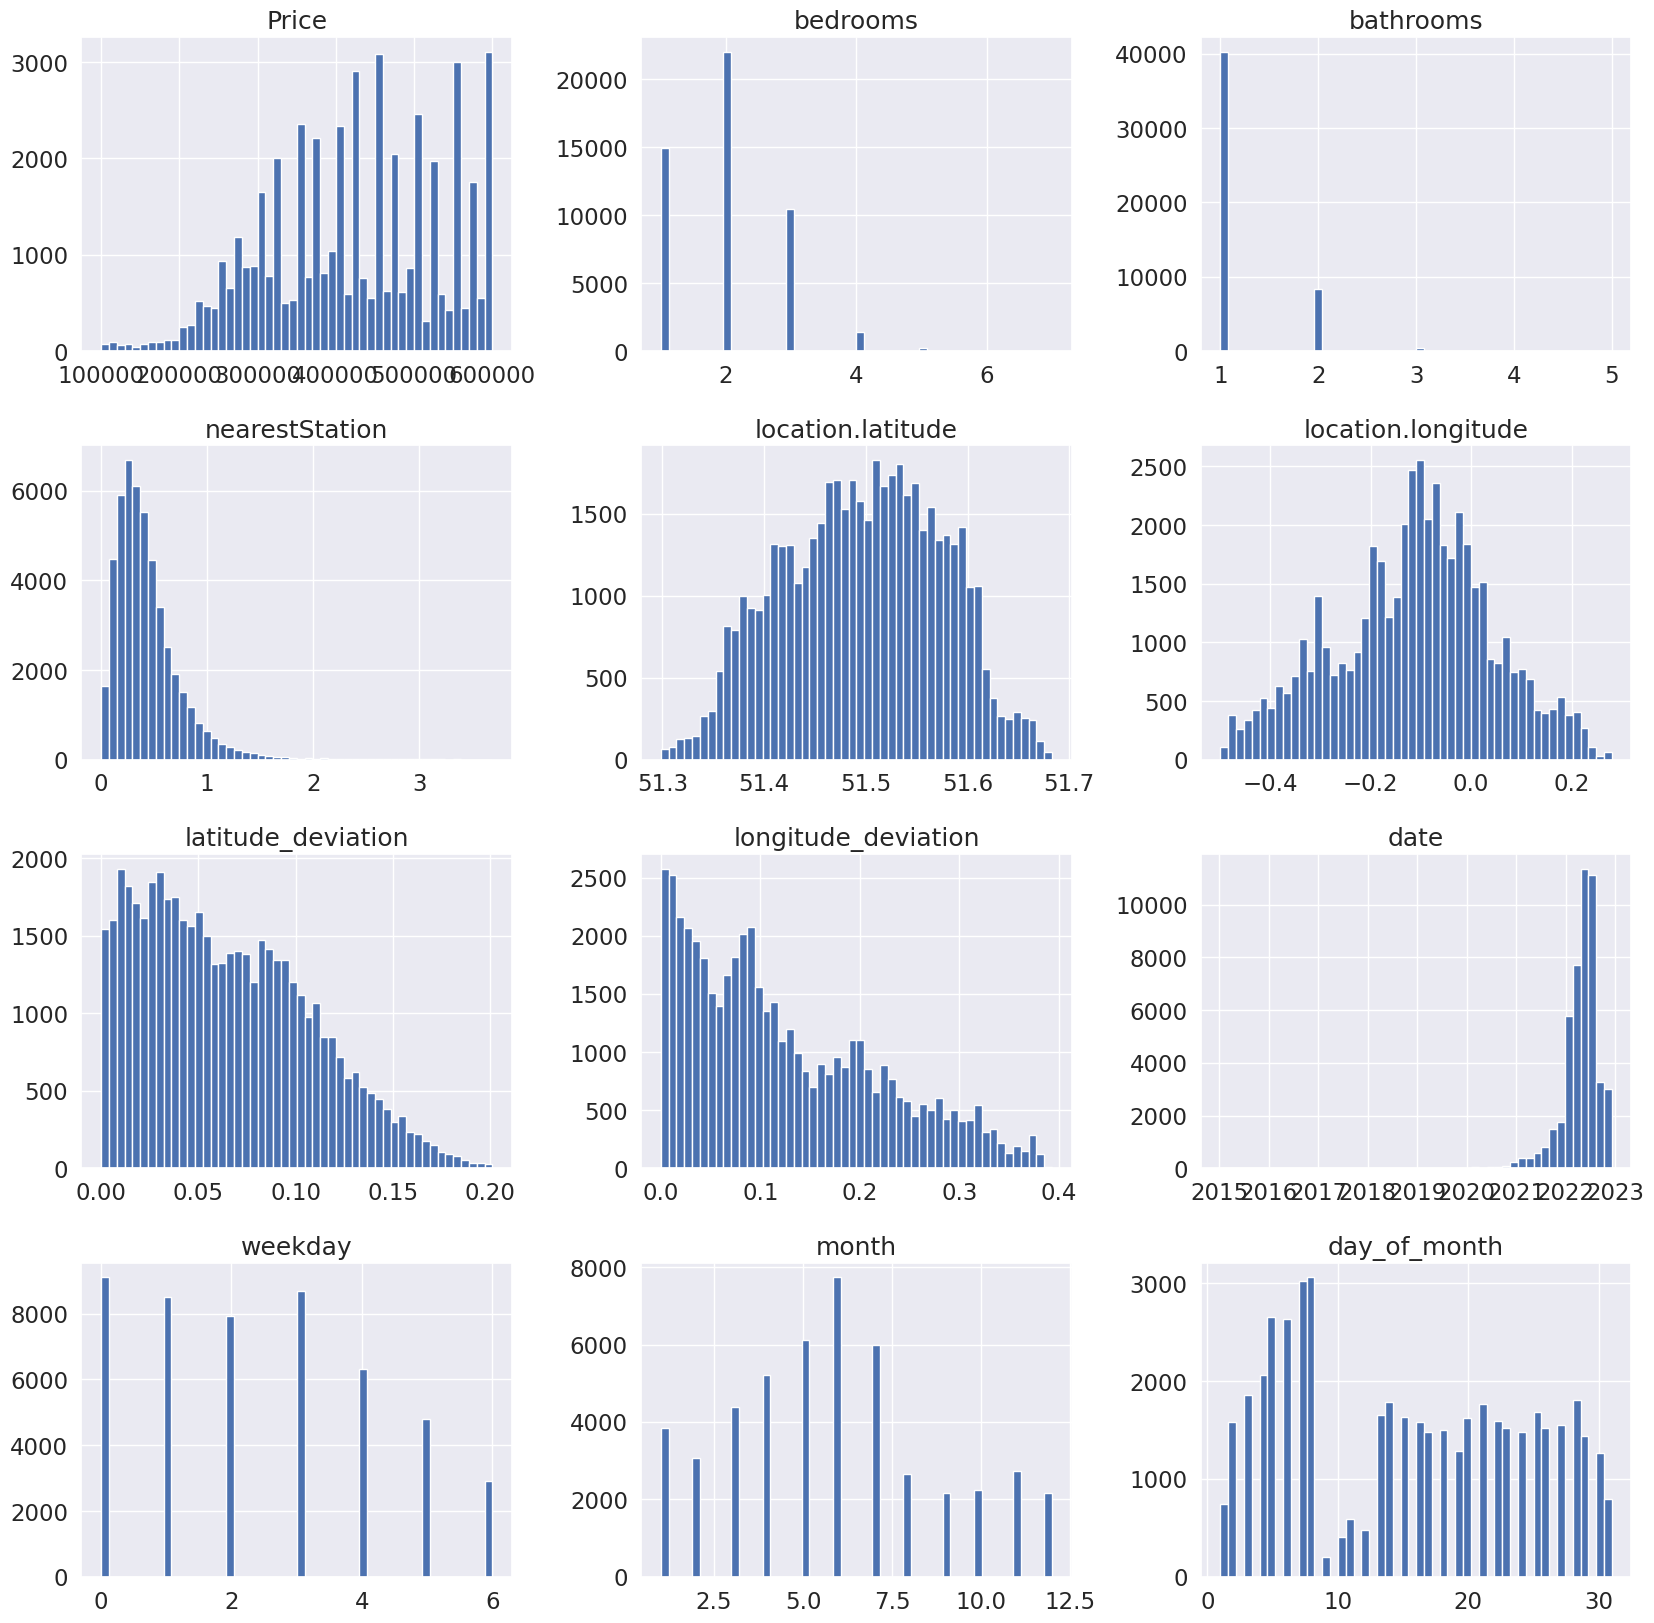

In [132]:
df.hist(bins=50, figsize=(20, 20))
plt.show()

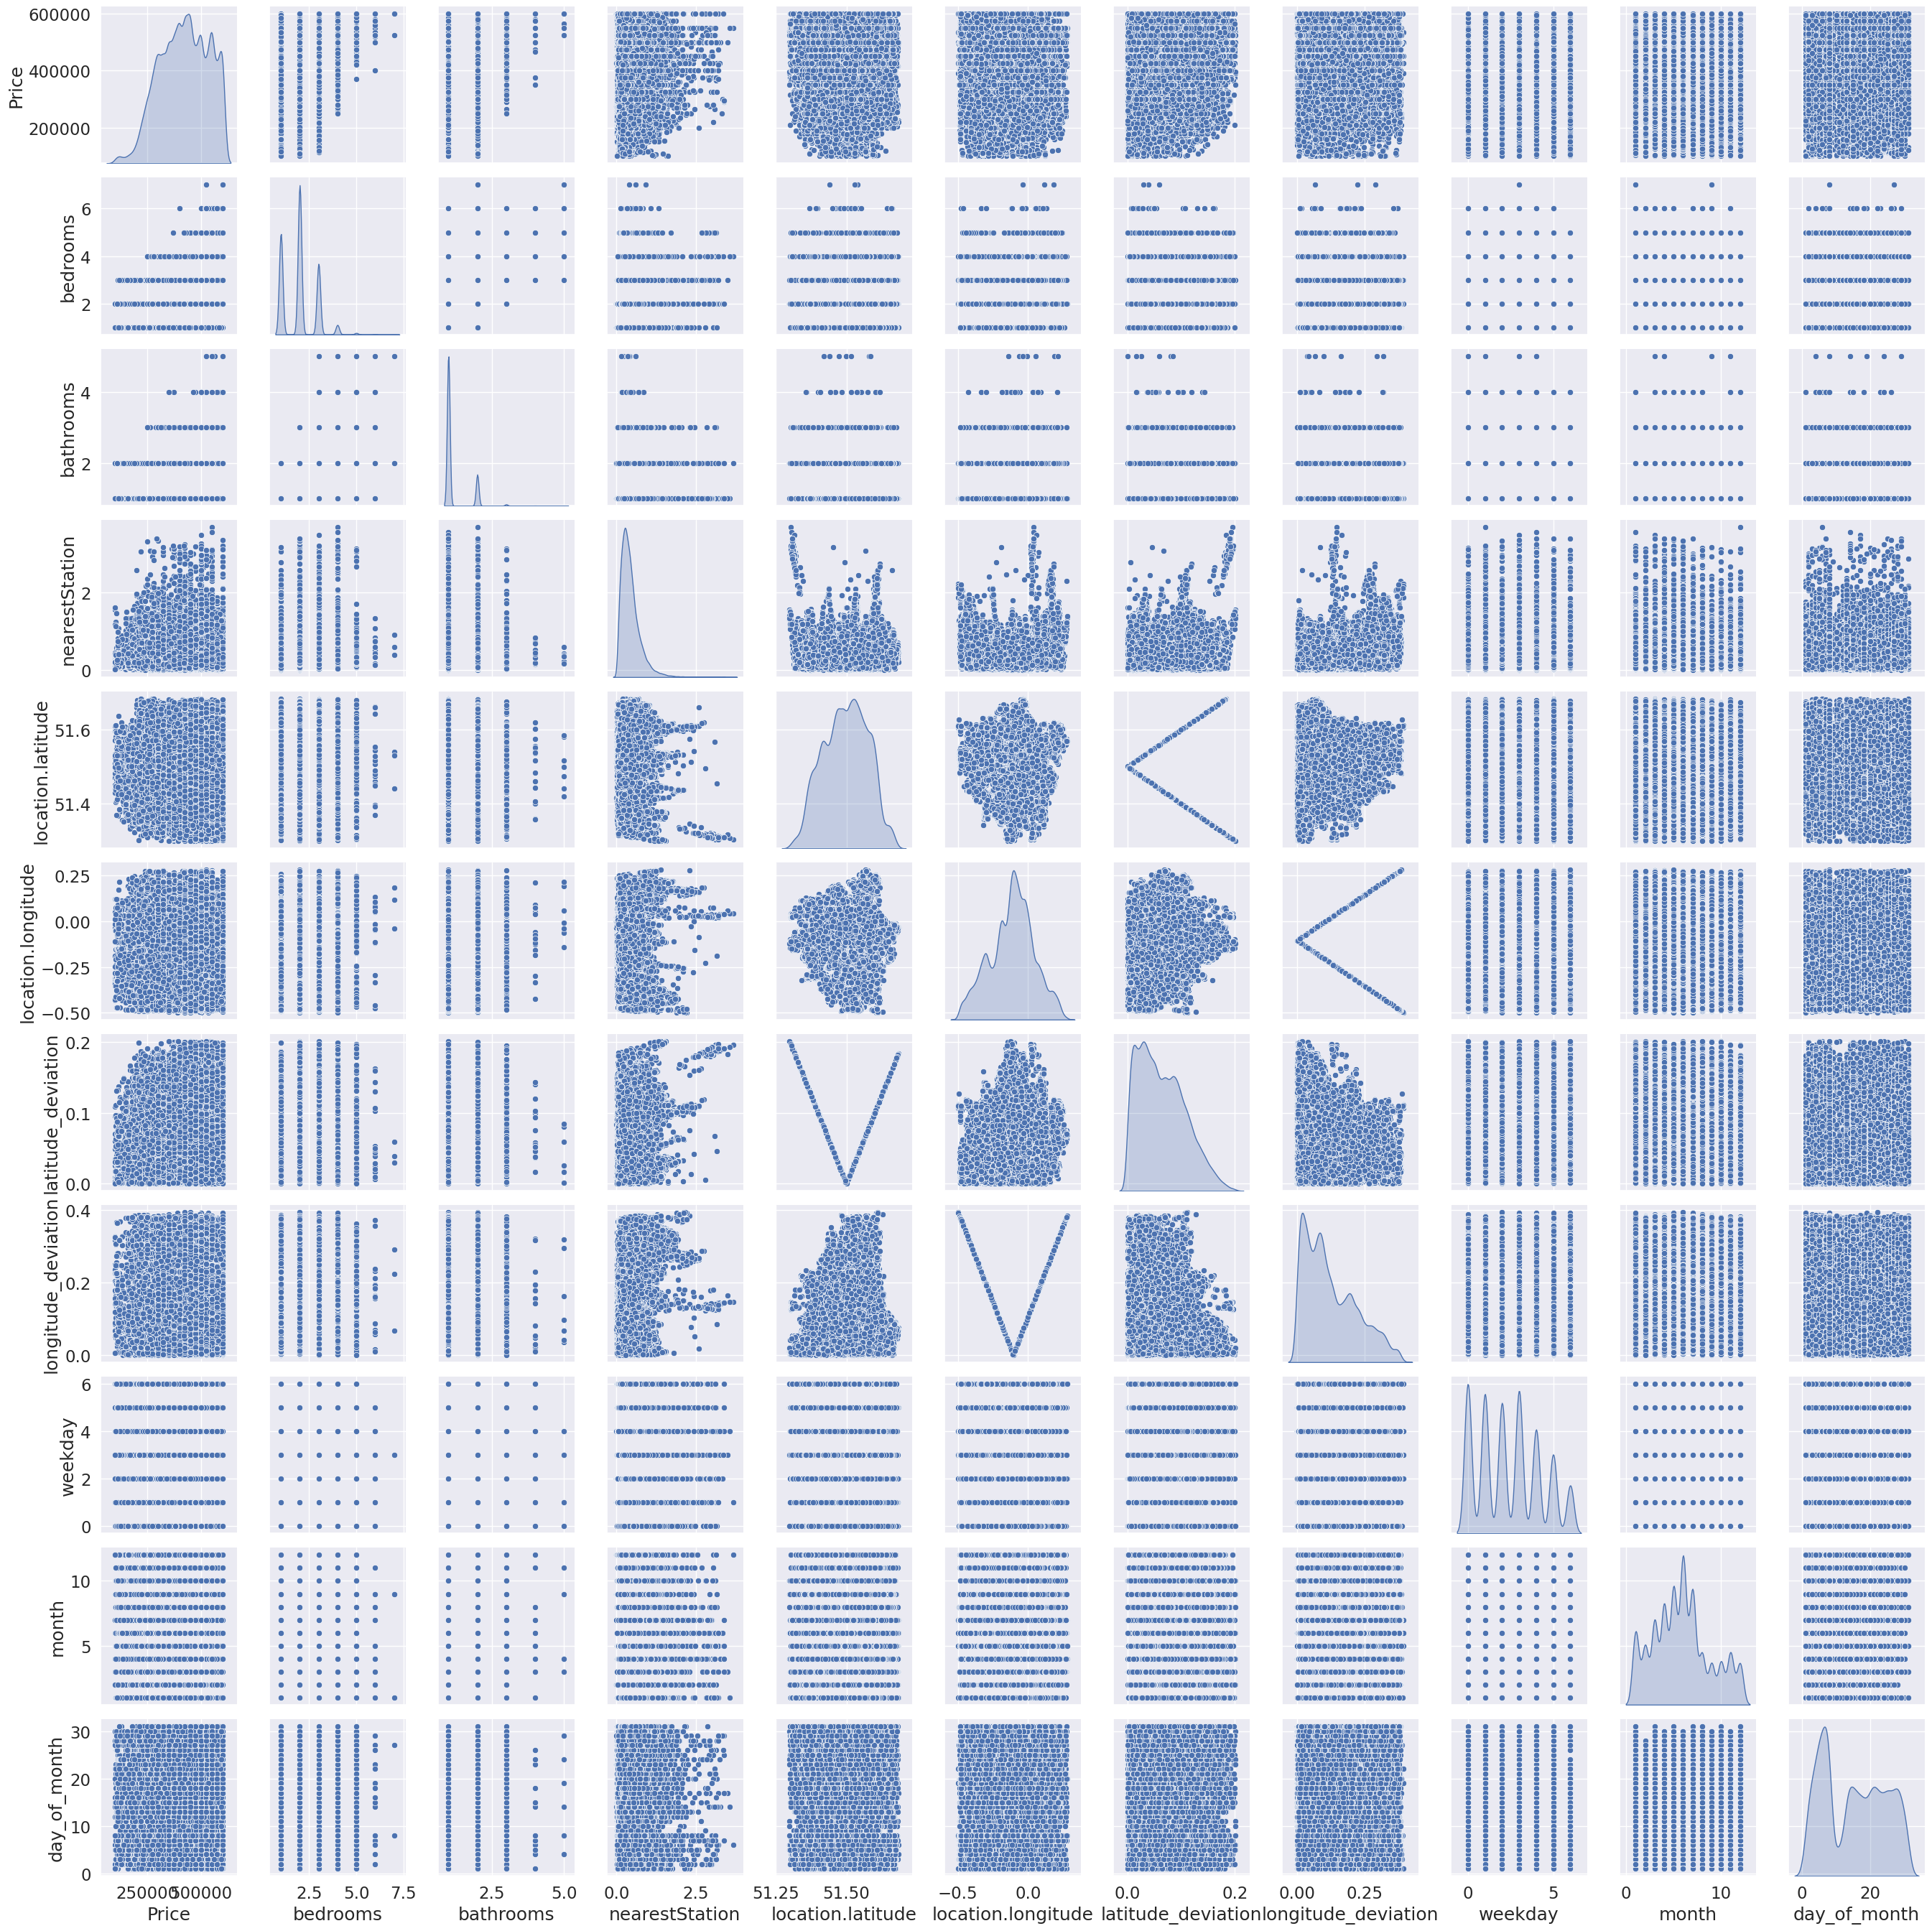

In [133]:
sns.pairplot(df, diag_kind='kde')

In [134]:
#df.isna().any()
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2871
date                    723
weekday                 723
month                   723
day_of_month            723
dtype: int64

In [135]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

49001 ==> 45448


Price      bedrooms     bathrooms  nearestStation  \
count   45448.000000  45448.000000  45448.000000    45448.000000   
mean   421306.624164      1.980857      1.185377        0.435404   
std    110722.486538      0.823010      0.411488        0.319498   
min    100000.000000      1.000000      1.000000        0.000000   
25%    339983.750000      1.000000      1.000000        0.225384   
50%    425000.000000      2.000000      1.000000        0.365839   
75%    500000.000000      2.000000      1.000000        0.556579   
max    600000.000000      7.000000      5.000000        3.687893   

       location.latitude  location.longitude  latitude_deviation  \
count       45448.000000        45448.000000        45448.000000   
mean           51.495933           -0.113922            0.064672   
std             0.077547            0.155743            0.042936   
min            51.298317           -0.498315            0.000000   
25%            51.437319           -0.211164            0.028738   
50%            51.498232           -0.103070            0.058940   
75%            51.555636           -0.011817            0.094838   
max            51.683185            0.279726            0.201161   

       longitude_deviation       weekday         month  day_of_month  
count         45448.000000  45448.000000  45448.000000  45448.000000  
mean              0.123526      2.433968      5.841863     15.271497  
std               0.095250      1.818895      2.977891      8.964303  
min               0.000000      0.000000      1.000000      1.000000  
25%               0.043226      1.000000      4.000000      7.000000  
50%               0.098472      2.000000      6.000000     15.000000  
75%               0.191662      4.000000      7.000000     23.000000  
max               0.393095      6.000000     12.000000     31.000000

In [136]:
df_features = df.drop(LABEL, axis=1)
df_features

bedrooms  bathrooms  nearestStation  location.latitude  \
14520525        3.0        1.0        0.274316          51.529950   
27953107        2.0        2.0        0.305845          51.549390   
33593487        2.0        1.0        0.438045          51.447180   
35271294        2.0        1.0        0.399307          51.449568   
44749111        2.0        1.0        0.410550          51.370050   
...             ...        ...             ...                ...   
126179018       2.0        1.0        0.682879          51.370651   
126179672       3.0        2.0        0.545665          51.357170   
126180107       2.0        1.0        0.191407          51.531415   
126180704       2.0        1.0        0.308609          51.543141   
126181118       2.0        1.0        0.238489          51.424589   

           location.longitude  latitude_deviation  longitude_deviation  \
14520525            -0.207020            0.030472             0.101800   
27953107            -0.482600            0.049912             0.377380   
33593487            -0.338770            0.052298             0.233550   
35271294            -0.140154            0.049910             0.034934   
44749111            -0.212410            0.129428             0.107190   
...                       ...                 ...                  ...   
126179018           -0.238346            0.128827             0.133126   
126179672           -0.074740            0.142308             0.030480   
126180107           -0.052964            0.031937             0.052256   
126180704            0.011498            0.043663             0.116718   
126181118           -0.206790            0.074889             0.101570   

           tenure.tenureType       date  weekday  month  day_of_month  
14520525           LEASEHOLD 2022-05-24      1.0    5.0          24.0  
27953107           LEASEHOLD 2022-06-16      3.0    6.0          16.0  
33593487            FREEHOLD 2022-11-07      0.0   11.0           7.0  
35271294           LEASEHOLD 2021-06-14      0.0    6.0          14.0  
44749111            FREEHOLD 2021-11-10      2.0   11.0          10.0  
...                      ...        ...      ...    ...           ...  
126179018           FREEHOLD 2022-08-18      3.0    8.0          18.0  
126179672          LEASEHOLD 2022-08-18      3.0    8.0          18.0  
126180107          LEASEHOLD 2022-08-18      3.0    8.0          18.0  
126180704          LEASEHOLD 2022-08-18      3.0    8.0          18.0  
126181118  SHARE_OF_FREEHOLD 2022-08-18      3.0    8.0          18.0  

[45448 rows x 12 columns]

In [137]:
use_one_hot_encoding_not_dummies = False

if use_one_hot_encoding_not_dummies:
    raise NotImplementedError('not implemented one hot encoding yet')

    #from sklearn.preprocessing import OneHotEncoder
    #tenure_encoder = OneHotEncoder()
    #df_tenure_type = tenure_encoder.fit_transform(df_features[['tenure.tenureType']])
else:
    for column in categories:
        df_features = pd.concat([df_features, pd.get_dummies(df_features[column], prefix=column, drop_first=True)],
                                axis=1)
        df_features.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

features_corr = df_features.corr()
features_corr

bedrooms  bathrooms  nearestStation  \
bedrooms                             1.000000   0.328976        0.244747   
bathrooms                            0.328976   1.000000        0.049761   
nearestStation                       0.244747   0.049761        1.000000   
location.latitude                    0.003476  -0.005180        0.023500   
location.longitude                   0.118063   0.016333        0.043703   
latitude_deviation                   0.196191   0.035412        0.161779   
longitude_deviation                  0.180718   0.077476        0.319729   
weekday                             -0.003226   0.010666        0.000702   
month                               -0.011291   0.005249       -0.013749   
day_of_month                        -0.001819  -0.003038        0.004296   
tenure.tenureType_FREEHOLD           0.591387   0.082498        0.313497   
tenure.tenureType_LEASEHOLD         -0.459316  -0.035380       -0.228103   
tenure.tenureType_SHARE_OF_FREEHOLD -0.113886  -0.058854       -0.083442   

                                     location.latitude  location.longitude  \
bedrooms                                      0.003476            0.118063   
bathrooms                                    -0.005180            0.016333   
nearestStation                                0.023500            0.043703   
location.latitude                             1.000000            0.095413   
location.longitude                            0.095413            1.000000   
latitude_deviation                           -0.123173            0.046741   
longitude_deviation                           0.188762           -0.168638   
weekday                                       0.003002            0.010448   
month                                        -0.001826           -0.003334   
day_of_month                                 -0.002657           -0.002787   
tenure.tenureType_FREEHOLD                    0.003167            0.137193   
tenure.tenureType_LEASEHOLD                   0.024552           -0.070039   
tenure.tenureType_SHARE_OF_FREEHOLD          -0.041306           -0.081586   

                                     latitude_deviation  longitude_deviation  \
bedrooms                                       0.196191             0.180718   
bathrooms                                      0.035412             0.077476   
nearestStation                                 0.161779             0.319729   
location.latitude                             -0.123173             0.188762   
location.longitude                             0.046741            -0.168638   
latitude_deviation                             1.000000            -0.185352   
longitude_deviation                           -0.185352             1.000000   
weekday                                        0.008322            -0.014645   
month                                         -0.015068            -0.008508   
day_of_month                                  -0.006184            -0.007769   
tenure.tenureType_FREEHOLD                     0.223598             0.274410   
tenure.tenureType_LEASEHOLD                   -0.209285            -0.176185   
tenure.tenureType_SHARE_OF_FREEHOLD            0.010744            -0.108407   

                                      weekday     month  day_of_month  \
bedrooms                            -0.003226 -0.011291     -0.001819   
bathrooms                            0.010666  0.005249     -0.003038   
nearestStation                       0.000702 -0.013749      0.004296   
location.latitude                    0.003002 -0.001826     -0.002657   
location.longitude                   0.010448 -0.003334     -0.002787   
latitude_deviation                   0.008322 -0.015068     -0.006184   
longitude_deviation                 -0.014645 -0.008508     -0.007769   
weekday                              1.000000  0.044787     -0.179238   
month                                0.044787  1.000000     -0.214763   
day_of_month                

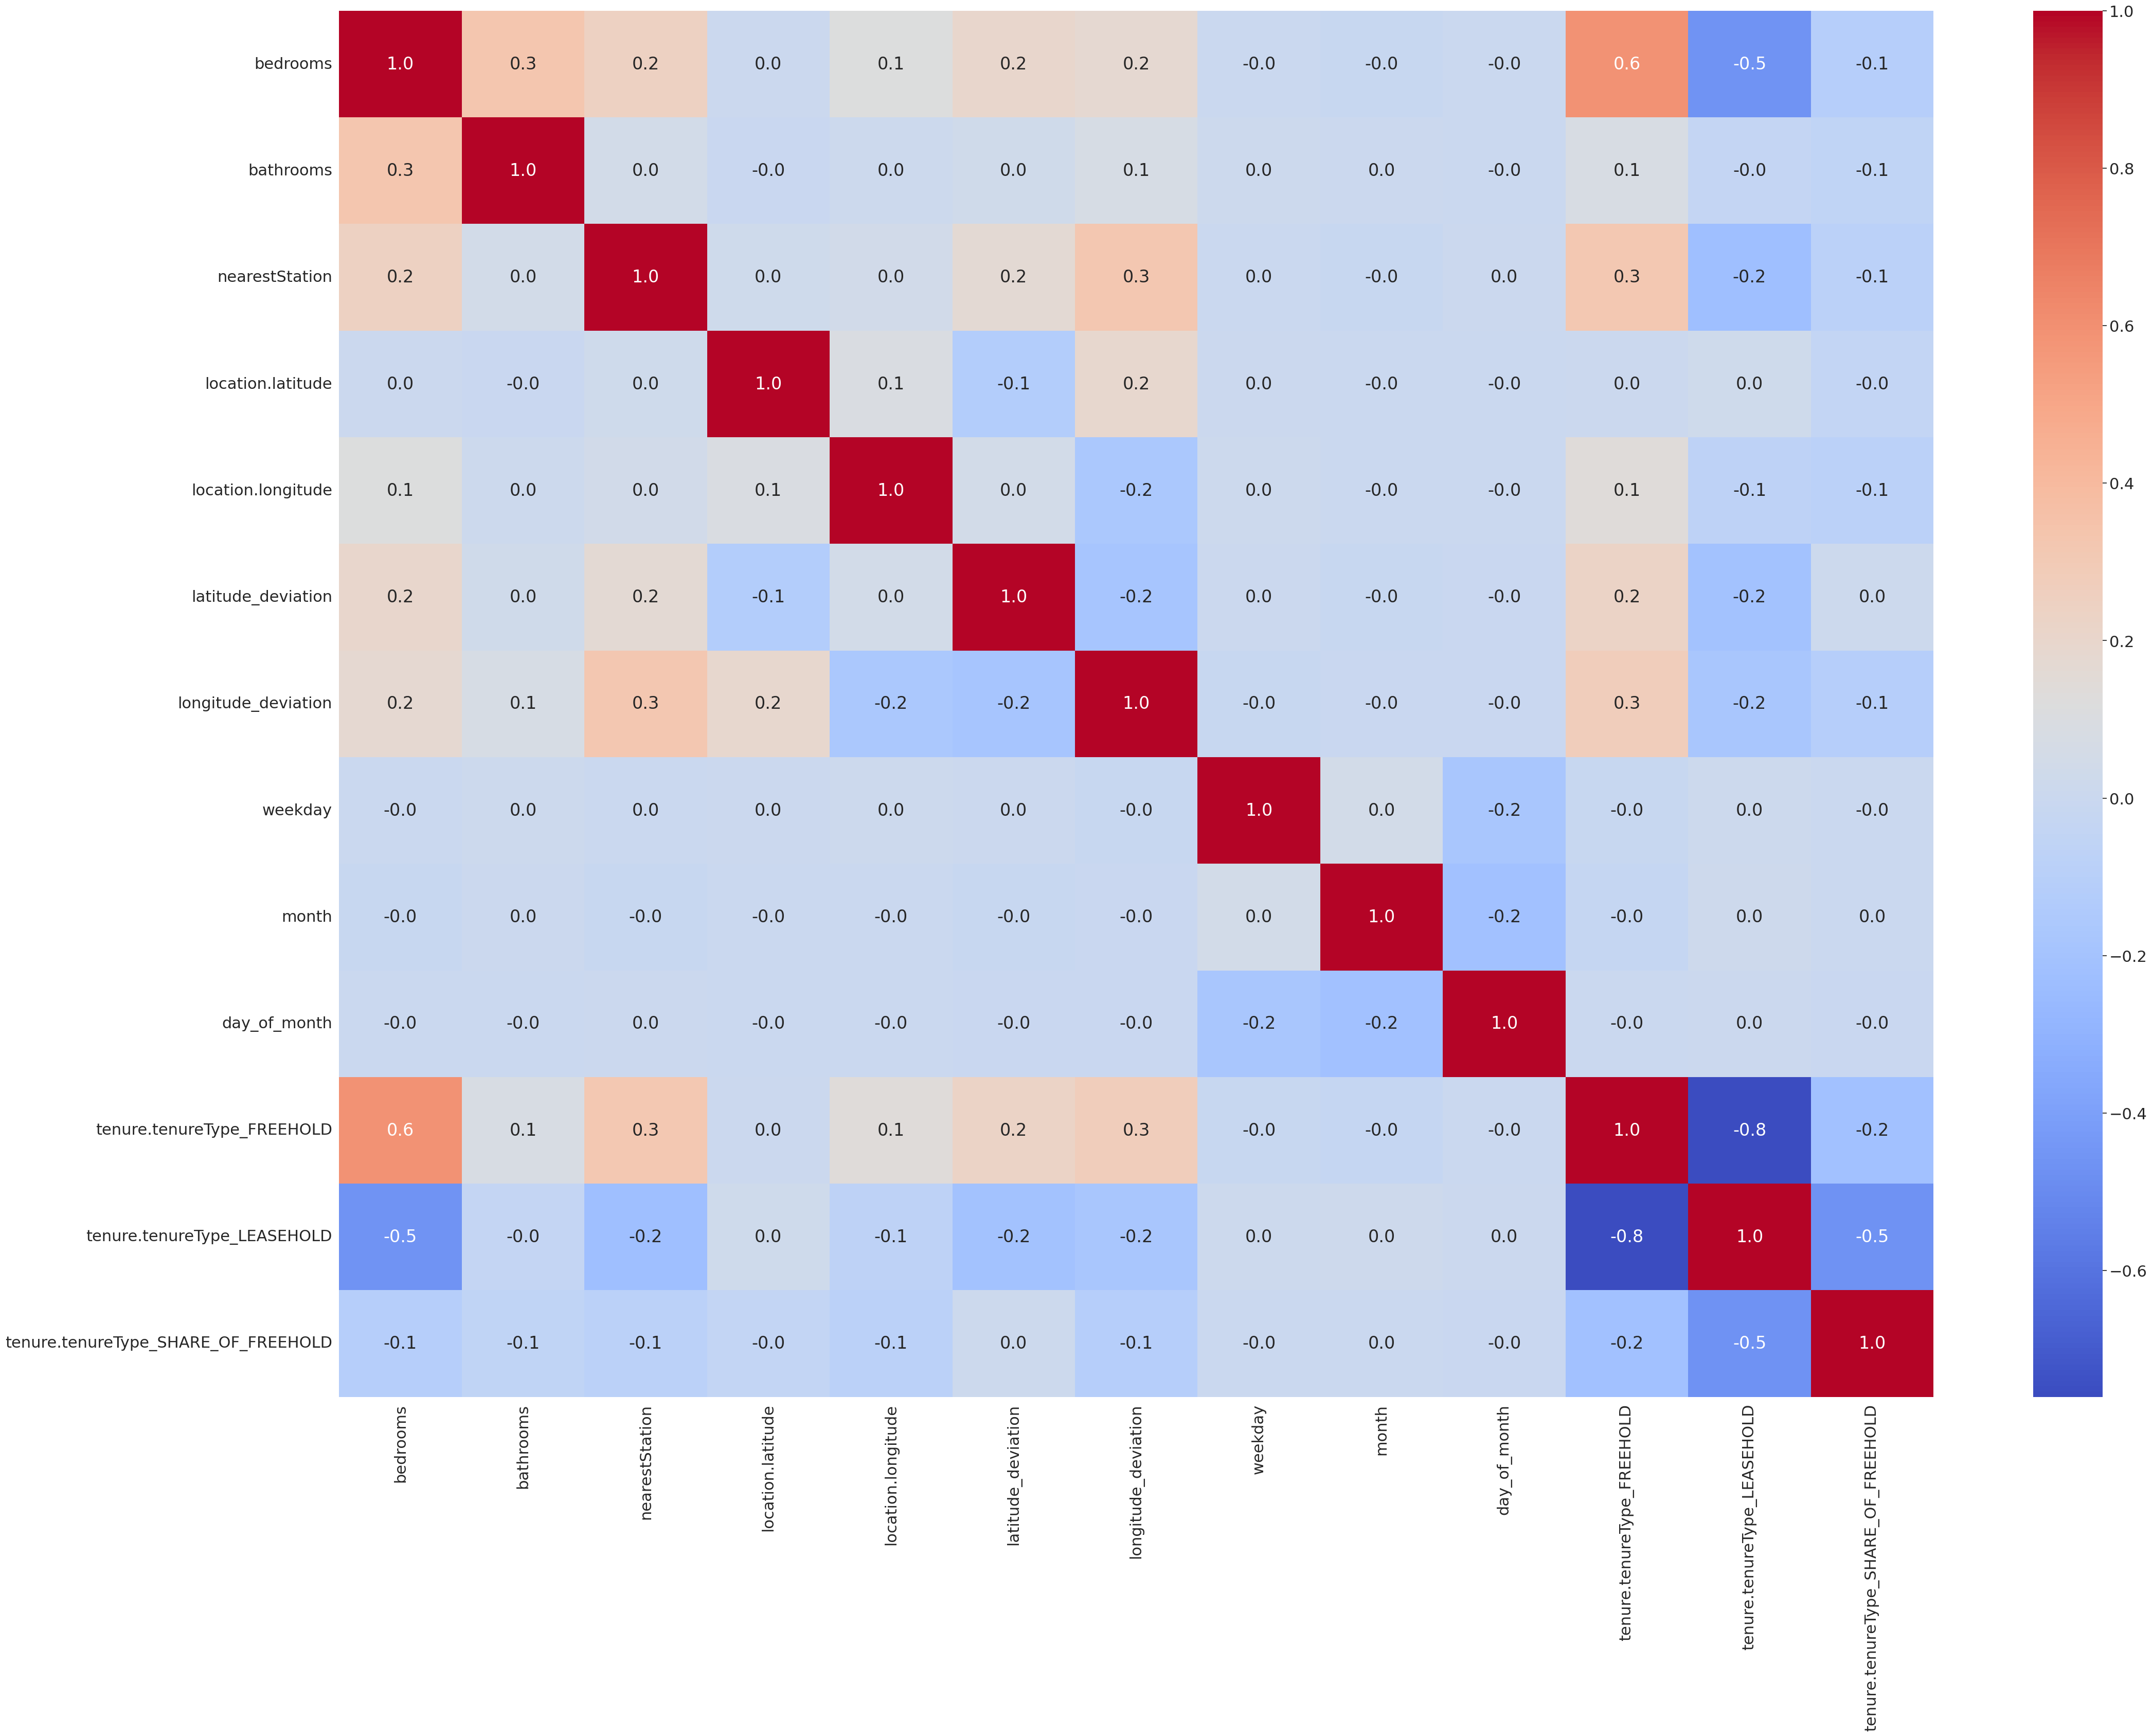

In [138]:
sns.set(font_scale=2)
plt.figure(figsize=(50, 35))
ax = sns.heatmap(features_corr, annot=True, fmt='.1f', cmap='coolwarm')

In [139]:
data_corr = df.corr()
data_corr_dict = data_corr["Price"].sort_values(ascending=False).to_dict()
data_corr_dict

{'Price': 1.0,
 'bedrooms': 0.46500257917045595,
 'bathrooms': 0.2526893702607734,
 'location.latitude': 0.0549839026382005,
 'day_of_month': -0.004977047981055403,
 'month': -0.005240882514027405,
 'weekday': -0.007935728142402428,
 'nearestStation': -0.009799482241639575,
 'location.longitude': -0.0646800794495967,
 'latitude_deviation': -0.07706013907444215,
 'longitude_deviation': -0.0783304488876165}

In [140]:
#print the most positively correlated features
pos_corr = {k: v for k, v in data_corr_dict.items() if v > 0.1 and v != 1}
pos_corr

{'bedrooms': 0.46500257917045595, 'bathrooms': 0.2526893702607734}

In [141]:
#print the most negatively correlated features
neg_corr = {k: v for k, v in data_corr_dict.items() if v < -0.1}
neg_corr

{}

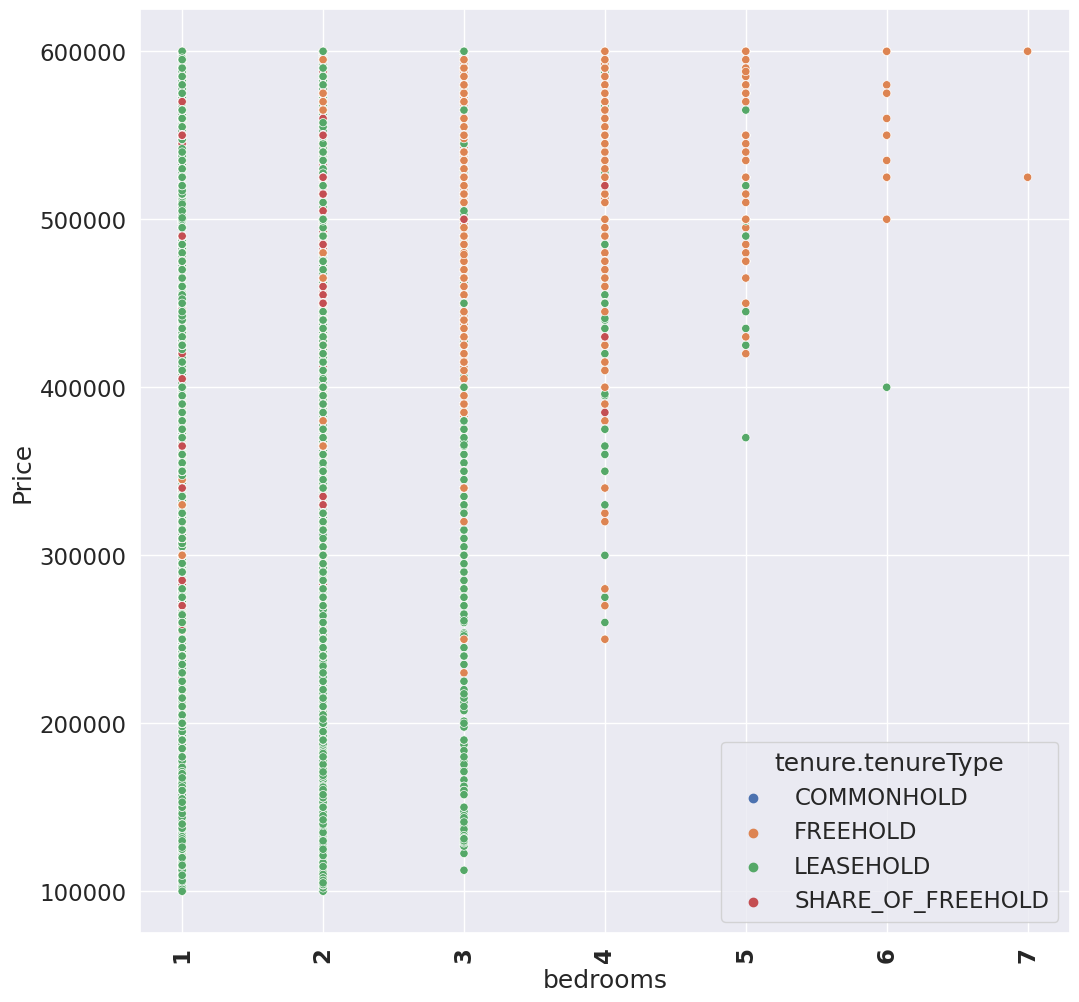

In [142]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='bedrooms', y='Price', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

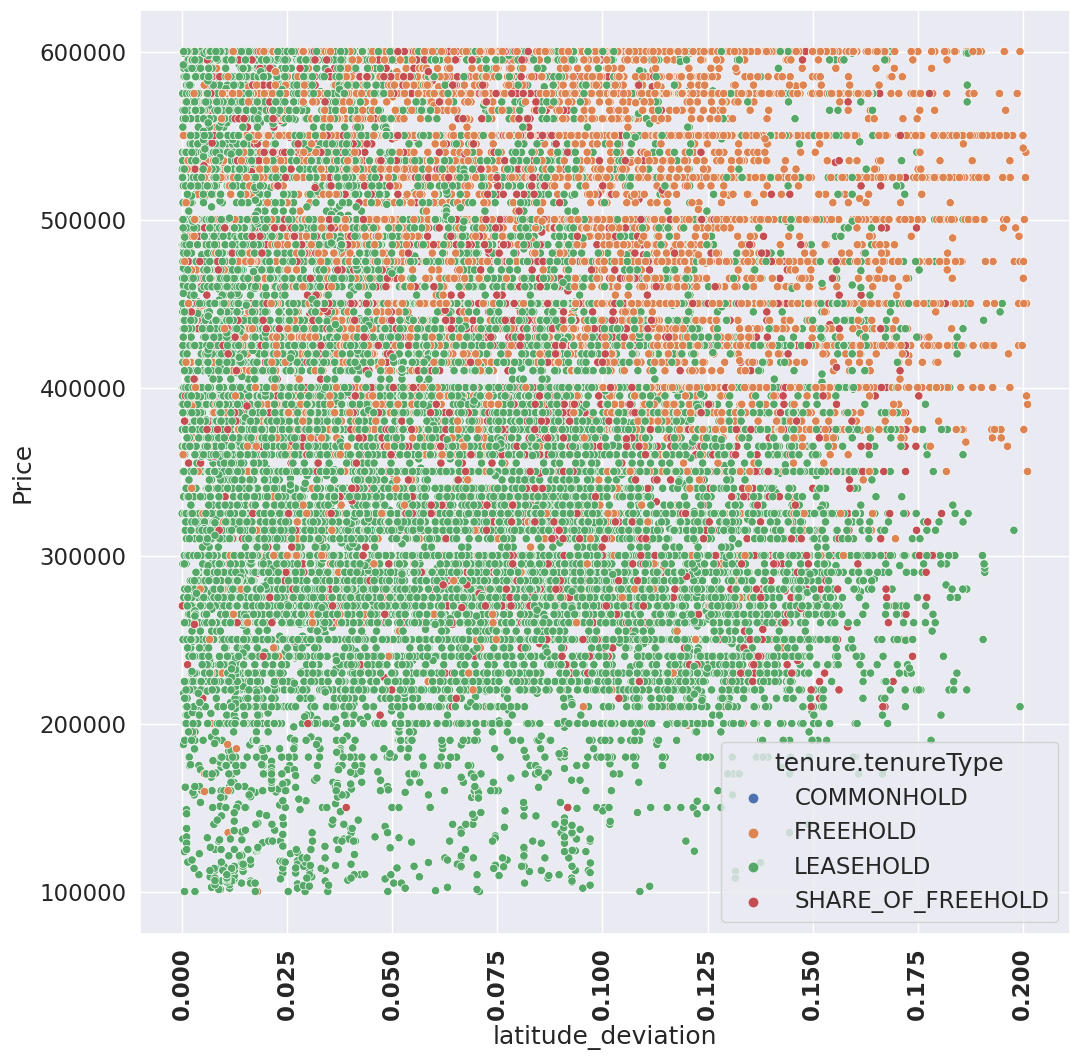

In [143]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='latitude_deviation', y='Price', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

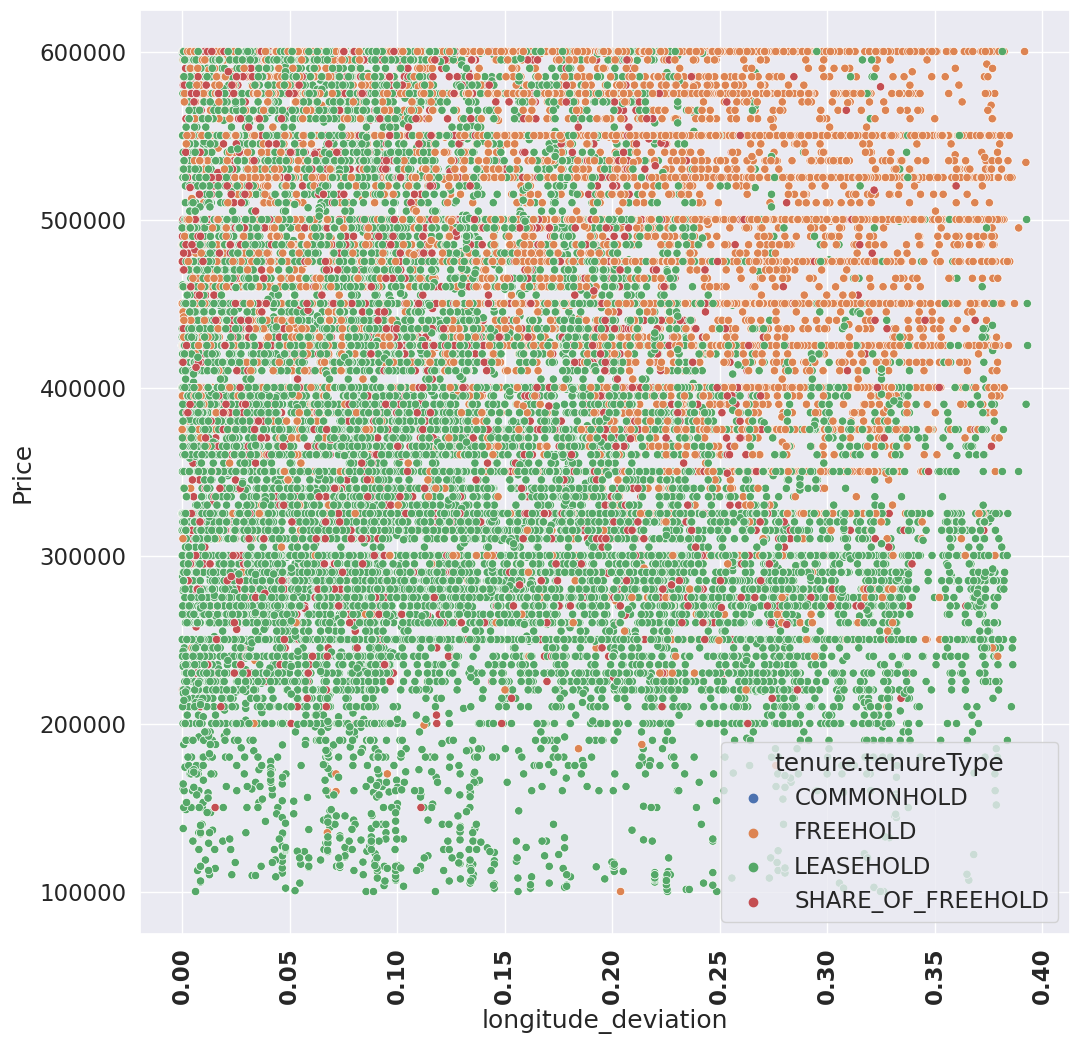

In [144]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='longitude_deviation', y='Price', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

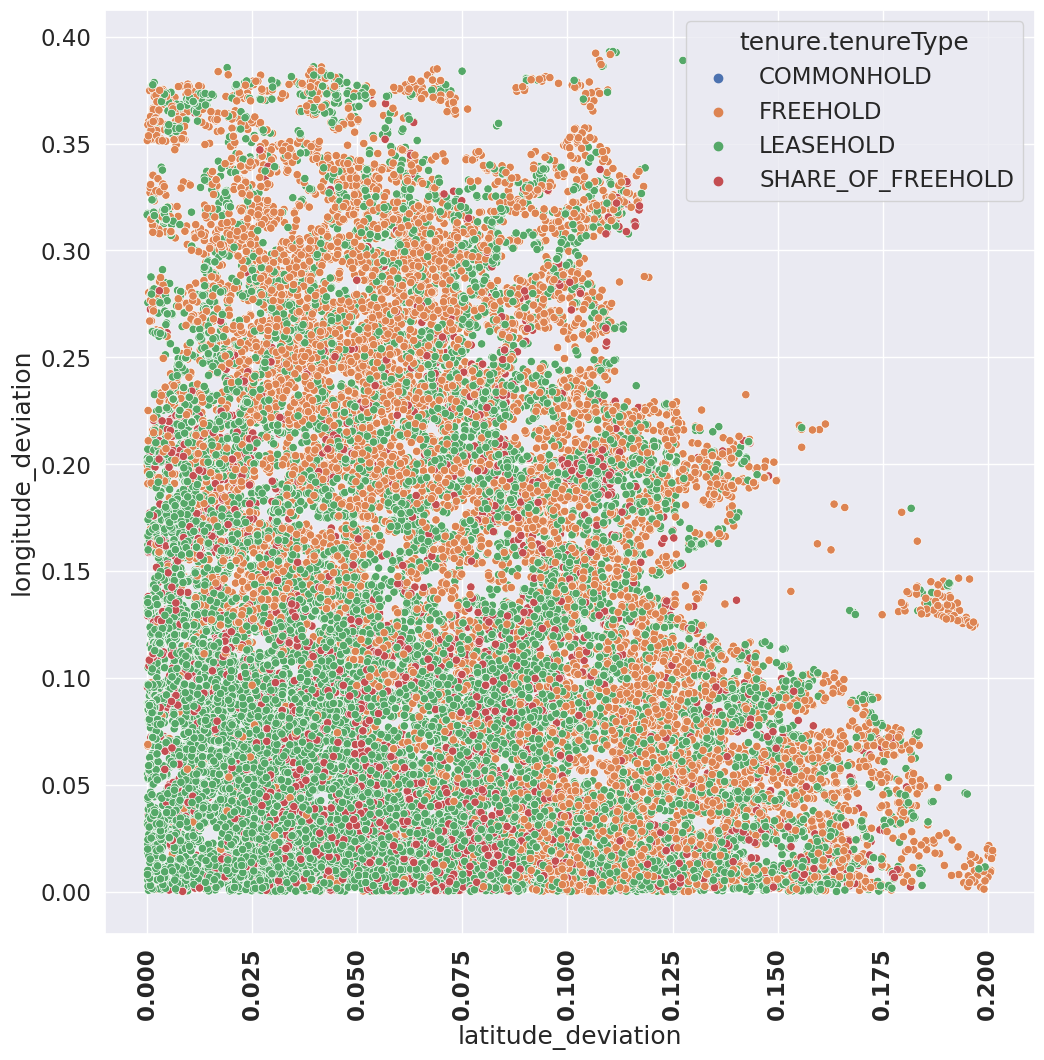

In [145]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='latitude_deviation', y='longitude_deviation', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    Exploration for imputation


</h2>
</div>

In [146]:
df['central_distance'] = (df['latitude_deviation'] ** 2 + df['longitude_deviation'] ** 2) ** 0.5
df

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
14520525   550000       3.0        1.0        0.274316          51.529950   
27953107   400000       2.0        2.0        0.305845          51.549390   
33593487   579950       2.0        1.0        0.438045          51.447180   
35271294   370000       2.0        1.0        0.399307          51.449568   
44749111   475000       2.0        1.0        0.410550          51.370050   
...           ...       ...        ...             ...                ...   
126179018  575000       2.0        1.0        0.682879          51.370651   
126179672  600000       3.0        2.0        0.545665          51.357170   
126180107  419999       2.0        1.0        0.191407          51.531415   
126180704  475000       2.0        1.0        0.308609          51.543141   
126181118  525000       2.0        1.0        0.238489          51.424589   

           location.longitude  latitude_deviation  longitude_deviation  \
14520525            -0.207020            0.030472             0.101800   
27953107            -0.482600            0.049912             0.377380   
33593487            -0.338770            0.052298             0.233550   
35271294            -0.140154            0.049910             0.034934   
44749111            -0.212410            0.129428             0.107190   
...                       ...                 ...                  ...   
126179018           -0.238346            0.128827             0.133126   
126179672           -0.074740            0.142308             0.030480   
126180107           -0.052964            0.031937             0.052256   
126180704            0.011498            0.043663             0.116718   
126181118           -0.206790            0.074889             0.101570   

           tenure.tenureType       date  weekday  month  day_of_month  \
14520525           LEASEHOLD 2022-05-24      1.0    5.0          24.0   
27953107           LEASEHOLD 2022-06-16      3.0    6.0          16.0   
33593487            FREEHOLD 2022-11-07      0.0   11.0           7.0   
35271294           LEASEHOLD 2021-06-14      0.0    6.0          14.0   
44749111            FREEHOLD 2021-11-10      2.0   11.0          10.0   
...                      ...        ...      ...    ...           ...   
126179018           FREEHOLD 2022-08-18      3.0    8.0          18.0   
126179672          LEASEHOLD 2022-08-18      3.0    8.0          18.0   
126180107          LEASEHOLD 2022-08-18      3.0    8.0          18.0   
126180704          LEASEHOLD 2022-08-18      3.0    8.0          18.0   
126181118  SHARE_OF_FREEHOLD 2022-08-18      3.0    8.0          18.0   

           central_distance  
14520525           0.106263  
27953107           0.380666  
33593487           0.239334  
35271294           0.060921  
44749111           0.168051  
...                     ...  
126179018          0.185254  
126179672          0.145536  
126180107          0.061243  
126180704          0.124618  
126181118          0.126194  

[45448 rows x 14 columns]

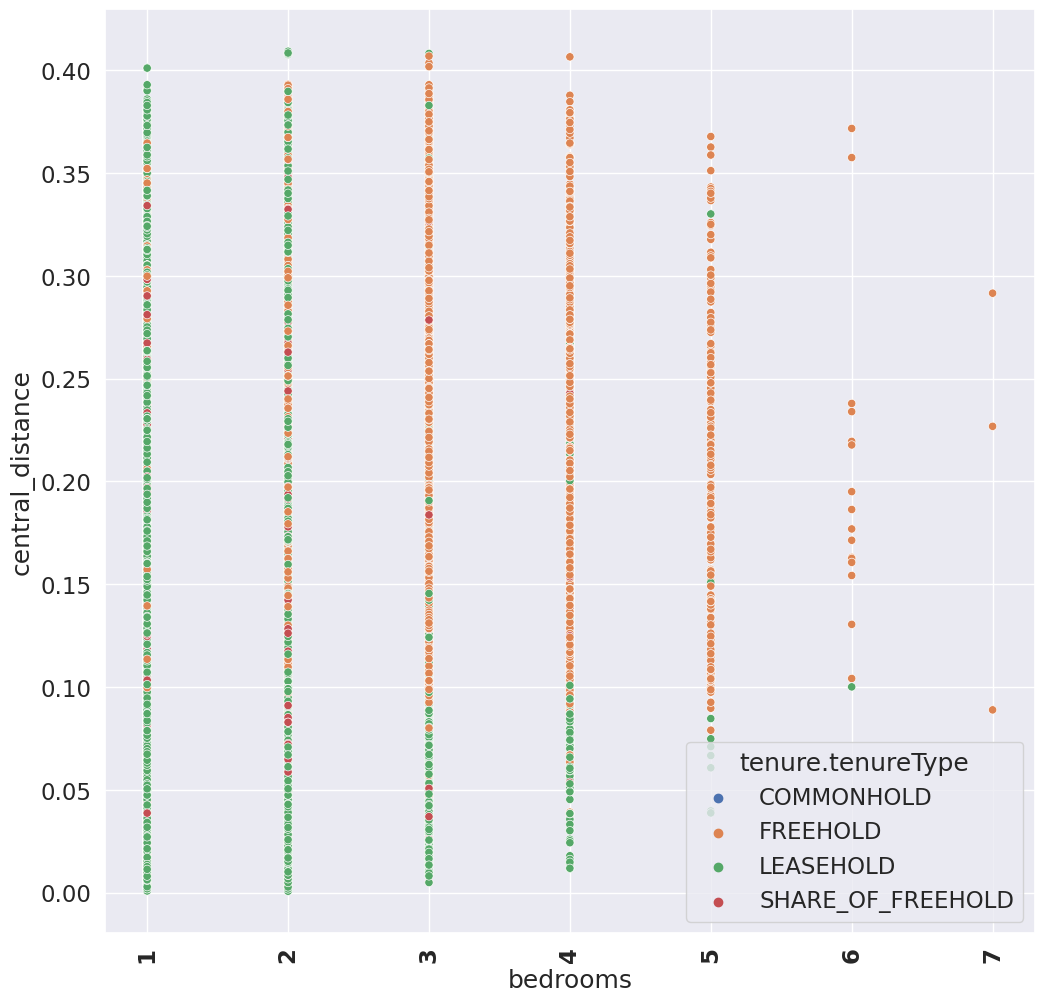

In [147]:

plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='bedrooms', y='central_distance', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

In [148]:
#df.groupby(['tenure.tenureType','bedrooms']).agg({'bedrooms':['mean','min','max']})
df.groupby(['tenure.tenureType', 'bedrooms']).agg('count')

Price  bathrooms  nearestStation  \
tenure.tenureType bedrooms                                     
COMMONHOLD        1.0           2          2               2   
                  2.0           5          5               5   
                  3.0           0          0               0   
                  4.0           0          0               0   
                  5.0           0          0               0   
                  6.0           0          0               0   
                  7.0           0          0               0   
FREEHOLD          1.0         337        337             337   
                  2.0        3231       3231            3231   
                  3.0        6947       6947            6947   
                  4.0        1111       1111            1111   
                  5.0         190        190             190   
                  6.0          16         16              16   
                  7.0           3          3               3   
LEASEHOLD         1.0       11528      11528           11528   
                  2.0       14247      14247           14247   
                  3.0        2308       2308            2308   
                  4.0         155        155             155   
                  5.0          11         11              11   
                  6.0           1          1               1   
                  7.0           0          0               0   
SHARE_OF_FREEHOLD 1.0        1942       1942            1942   
                  2.0        2973       2973            2973   
                  3.0         416        416             416   
                  4.0          25         25              25   
                  5.0           0          0               0   
                  6.0           0          0               0   
                  7.0           0          0               0   

                            location.latitude  location.longitude  \
tenure.tenureType bedrooms                                          
COMMONHOLD        1.0                       2                   2   
                  2.0                       5                   5   
                  3.0                       0                   0   
                  4.0                       0                   0   
                  5.0                       0                   0   
                  6.0                       0                   0   
                  7.0                       0                   0   
FREEHOLD          1.0                     337                 337   
                  2.0                    3231                3231   
                  3.0                    6947                6947   
                  4.0                    1111                1111   
                  5.0                     190                 190   
                  6.0                      16                  16   
                  7.0                       3                   3   
LEASEHOLD         1.0                   11528               11528   
                  2.0                   14247               14247   
                  3.0                    2308                2308   
                  4.0                     155                 155   
                  5.0                      11                  11   
                  6.0                       1                   1   
                  7.0                       0                   0   
SHARE_OF_FREEHOLD 1.0                    1942                1942   
                  2.0                    2973                2973   
                  3.0                     416                 416   
                  4.0                      25                  25   
                  5.0                       0                   0   
                  6.0                       0                   0   
                  7.0                       0                   0   

                            latitude

<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    Exploring dates


</h2>
</div>

In [149]:
def get_weekday(date):
    return date.weekday()

df['date'] = df['date'].map(pd.to_datetime)
df['weekday'] = df['date'].map(get_weekday)
df['month'] = df['date'].map(lambda x : x.month)
df['day_of_month'] = df['date'].map(lambda x : x.day)
df

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
14520525   550000       3.0        1.0        0.274316          51.529950   
27953107   400000       2.0        2.0        0.305845          51.549390   
33593487   579950       2.0        1.0        0.438045          51.447180   
35271294   370000       2.0        1.0        0.399307          51.449568   
44749111   475000       2.0        1.0        0.410550          51.370050   
...           ...       ...        ...             ...                ...   
126179018  575000       2.0        1.0        0.682879          51.370651   
126179672  600000       3.0        2.0        0.545665          51.357170   
126180107  419999       2.0        1.0        0.191407          51.531415   
126180704  475000       2.0        1.0        0.308609          51.543141   
126181118  525000       2.0        1.0        0.238489          51.424589   

           location.longitude  latitude_deviation  longitude_deviation  \
14520525            -0.207020            0.030472             0.101800   
27953107            -0.482600            0.049912             0.377380   
33593487            -0.338770            0.052298             0.233550   
35271294            -0.140154            0.049910             0.034934   
44749111            -0.212410            0.129428             0.107190   
...                       ...                 ...                  ...   
126179018           -0.238346            0.128827             0.133126   
126179672           -0.074740            0.142308             0.030480   
126180107           -0.052964            0.031937             0.052256   
126180704            0.011498            0.043663             0.116718   
126181118           -0.206790            0.074889             0.101570   

           tenure.tenureType       date  weekday  month  day_of_month  \
14520525           LEASEHOLD 2022-05-24        1      5            24   
27953107           LEASEHOLD 2022-06-16        3      6            16   
33593487            FREEHOLD 2022-11-07        0     11             7   
35271294           LEASEHOLD 2021-06-14        0      6            14   
44749111            FREEHOLD 2021-11-10        2     11            10   
...                      ...        ...      ...    ...           ...   
126179018           FREEHOLD 2022-08-18        3      8            18   
126179672          LEASEHOLD 2022-08-18        3      8            18   
126180107          LEASEHOLD 2022-08-18        3      8            18   
126180704          LEASEHOLD 2022-08-18        3      8            18   
126181118  SHARE_OF_FREEHOLD 2022-08-18        3      8            18   

           central_distance  
14520525           0.106263  
27953107           0.380666  
33593487           0.239334  
35271294           0.060921  
44749111           0.168051  
...                     ...  
126179018          0.185254  
126179672          0.145536  
126180107          0.061243  
126180704          0.124618  
126181118          0.126194  

[45448 rows x 14 columns]

<AxesSubplot: >

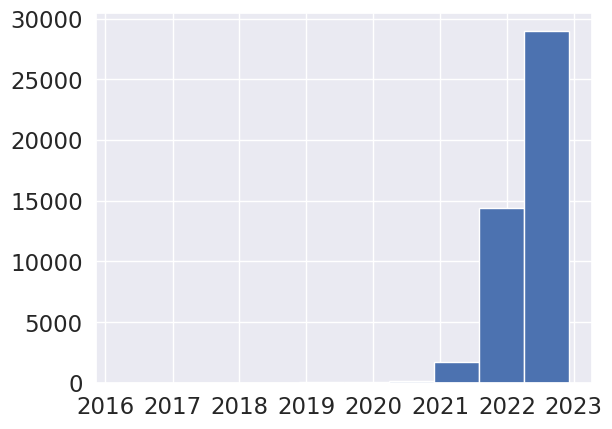

In [150]:
#hist(df['date'])
df['date'].hist()

<AxesSubplot: >

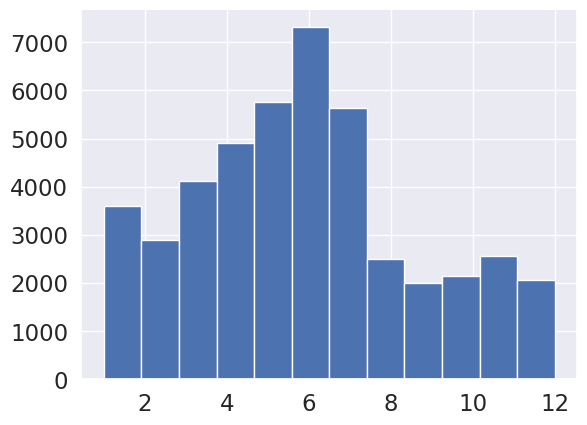

In [151]:
#hist(df['date'])
df['month'].hist(bins=12)

<AxesSubplot: >

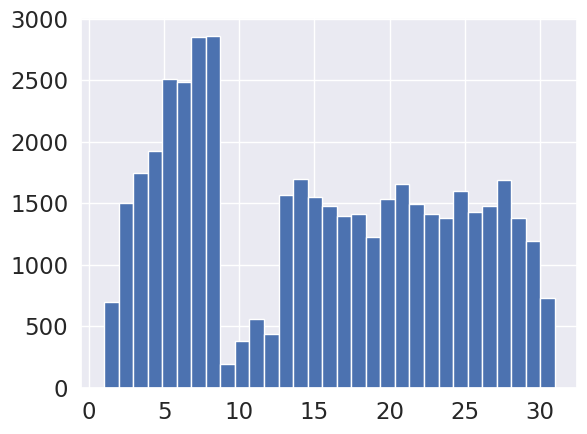

In [152]:
#hist(df['date'])
df['day_of_month'].hist(bins=31)

''

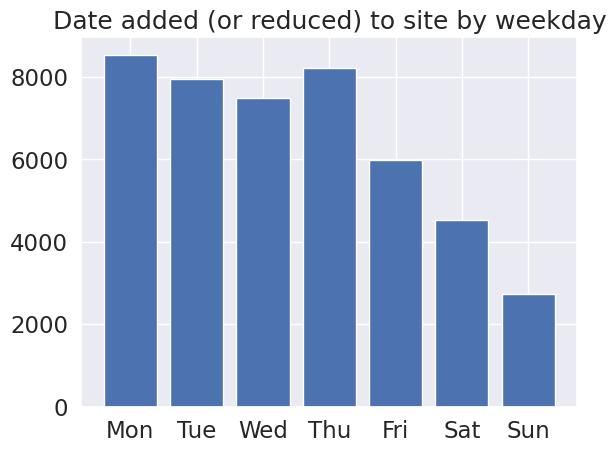

In [153]:
from matplotlib.pyplot import xticks, title

#hist(df['date'])
df['weekday'].hist(bins=7, range=(-.5,6.5), rwidth=.8) #, color='blue')
#df['weekday'].hist(bins=7)
xticks(range(7), 'Mon Tue Wed Thu Fri Sat Sun'.split())
title("Date added (or reduced) to site by weekday")
;

In [154]:
df['weekday'].value_counts(dropna=False)

0    8539
3    8213
1    7946
2    7492
4    5979
5    4540
6    2739
Name: weekday, dtype: int64

In [155]:
def get_weekday_name(weekday):
    if 0 <= weekday <= 8:
        return '0:Mon 1:Tue 2:Wed 3:Thu 4:Fri 5:Sat 6:Sun'.split()[int(weekday)]
    return None

df['weekday_name'] = df['weekday'].apply(get_weekday_name)
by_cross = df.groupby(['weekday_name','tenure.tenureType']).apply(lambda rows: len(rows)).unstack()
by_cross

tenure.tenureType  COMMONHOLD  FREEHOLD  LEASEHOLD  SHARE_OF_FREEHOLD
weekday_name                                                         
0:Mon                     1.0    2383.0     5169.0              986.0
1:Tue                     1.0    2057.0     4948.0              940.0
2:Wed                     2.0    1986.0     4592.0              912.0
3:Thu                     1.0    1997.0     5190.0             1025.0
4:Fri                     1.0    1408.0     3883.0              687.0
5:Sat                     1.0    1304.0     2760.0              475.0
6:Sun                     NaN     700.0     1708.0              331.0

<AxesSubplot: xlabel='tenure.tenureType', ylabel='weekday_name'>

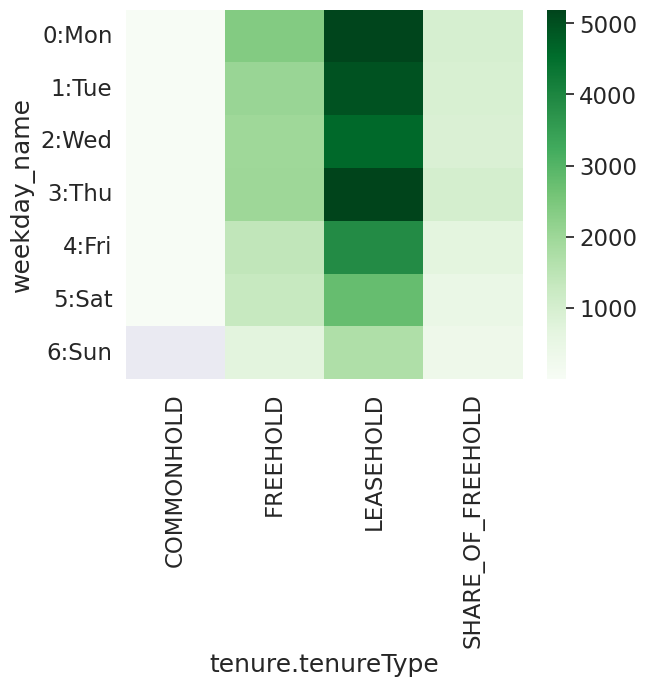

In [156]:
sns.heatmap(by_cross, cmap='Greens')

''

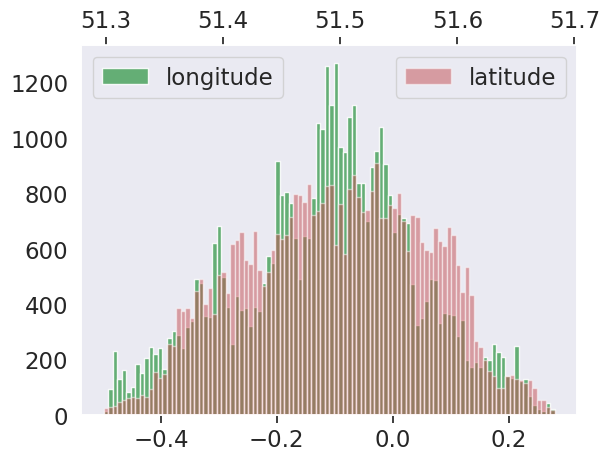

In [181]:
from matplotlib.pyplot import hist, grid, twiny, legend

hist(df['location.longitude'], bins=100, color='g', alpha=.9, label='longitude')
grid()
legend(loc='upper left')
twiny()
hist(df['location.latitude'], bins=100, color='r', alpha=.5, label='latitude')
grid()
legend(loc='best')
;

In [193]:
df.groupby('tenure.tenureType').count()

Price  bedrooms  bathrooms  nearestStation  \
tenure.tenureType                                               
COMMONHOLD             7         7          7               7   
FREEHOLD           11835     11835      11835           11835   
LEASEHOLD          28250     28250      28250           28250   
SHARE_OF_FREEHOLD   5356      5356       5356            5356   

                   location.latitude  location.longitude  latitude_deviation  \
tenure.tenureType                                                              
COMMONHOLD                         7                   7                   7   
FREEHOLD                       11835               11835               11835   
LEASEHOLD                      28250               28250               28250   
SHARE_OF_FREEHOLD               5356                5356                5356   

                   longitude_deviation   date  weekday  month  day_of_month  \
tenure.tenureType                                                             
COMMONHOLD                           7      7        7      7             7   
FREEHOLD                         11835  11835    11835  11835         11835   
LEASEHOLD                        28250  28250    28250  28250         28250   
SHARE_OF_FREEHOLD                 5356   5356     5356   5356          5356   

                   central_distance  weekday_name  
tenure.tenureType                                  
COMMONHOLD                        7             7  
FREEHOLD                      11835         11835  
LEASEHOLD                     28250         28250  
SHARE_OF_FREEHOLD              5356          5356

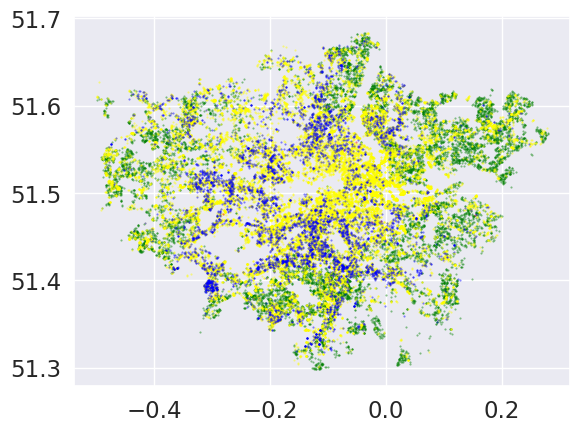

In [196]:
from matplotlib.pyplot import plot

sample = df.sample(40000)
sample = df
ss1 = sample[sample['tenure.tenureType'] == 'FREEHOLD']
ss2 = sample[sample['tenure.tenureType'] == 'LEASEHOLD']
ss3 = sample[sample['tenure.tenureType'] == 'COMMONHOLD']
ss4 = sample[sample['tenure.tenureType'] == 'SHARE_OF_FREEHOLD']

plot(ss1['location.longitude'],ss1['location.latitude'], '.', ms=1, alpha=.5, c='green')
plot(ss2['location.longitude'],ss2['location.latitude'], '.', ms=1, alpha=.5, c='yellow')
plot(ss3['location.longitude'],ss3['location.latitude'], '.', ms=1, alpha=.5, c='red')
plot(ss4['location.longitude'],ss4['location.latitude'], '.', ms=1, alpha=.5, c='blue')
#xlim(51, 52)
#ylim(51, 52)